In [17]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import os
import json
import time
import re

import psycopg2
import pandas.io.sql as sqlio

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

from multiprocessing import Process, Manager, Pool
import multiprocessing
from functools import partial

from collections import Counter

import seaborn as sns; sns.set()

import matplotlib
matplotlib.style.use('seaborn')
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['backend'] = "Qt5Agg"
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

from IPython.display import display, Image

from adjustText import adjust_text

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
# example of a configuration for connection to the "gtex_ipsa" PostgreSQL database. 
# Please update it according to your configuration settings

conn = psycopg2.connect(database='gtex_ipsa', user='postgres', host='localhost', port='5439')

In [13]:
import importlib
import helper_functions as aaf
importlib.reload(aaf)

<module 'AS_analysis_functions_2' from '/mnt/lustre/magmir/TASS/AS_analysis_functions_2.py'>

# Evidence of binding for validated USEs in POSTAR3

In [3373]:
leus = pd.read_csv('./misc/Literature_examples_of_unproductive_splicing.txt',delimiter="\t",
                                   index_col=None,header=0)
leus = leus.fillna('')

cols = ['Target','AS event position','AS type','PTC position','rMATS AS type','NMD site upstream hg19','NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']
leus_df = leus[cols].drop_duplicates().reset_index(drop=True)
leus_df = leus_df.loc[leus_df['Target']!='']

cols = ['NMD site upstream hg19', 'NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']

def get_chr(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    example = df.loc[df['col'].isin(cols)].iloc[0]['value']
    return example.split('_')[0]

def get_str(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    example = df.loc[df['col'].isin(cols)].iloc[0]['value']
    return example.split('_')[-1]

def get_start_pos(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    return min(df.loc[df['col'].isin(cols)]['value'].str.split('_',expand=True)[1].astype('int'))

def get_end_pos(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    a = []
    for val in list(df.loc[df['col'].isin(cols)]['value']):
        l = val.split('_')
        if len(l)==3:
            a.append(l[1])
        elif len(l)==4:
            a.append(l[2])
    return max(pd.Series(a).astype('int'))

leus_df['chr'] = leus_df.apply(lambda x: get_chr(x,cols),1)
leus_df['str'] = leus_df.apply(lambda x: get_str(x,cols),1)
leus_df['start_pos'] = leus_df.apply(lambda x: get_start_pos(x,cols),1)
leus_df['end_pos'] = leus_df.apply(lambda x: get_end_pos(x,cols),1)

leus_df['start_pos'] = leus_df['start_pos']-20
leus_df['end_pos'] = leus_df['end_pos']+20

In [ ]:
# we extract "gene" objects from the annotation using the following bash commands:
# awk '$3 == "gene"' gencode.v35lift37.annotation.gtf | gzip > genes_hg19.gtf.gz

In [3377]:
genes_hg19 = pd.read_csv('./Annotation/genes_hg19.gtf.gz',delimiter="\t",
                               index_col=None,header=None,compression='gzip')
genes_hg19 = genes_hg19[[0,3,4,6,8]]
genes_hg19.columns = ['chr','start','end','strand','tmp']
genes_hg19['Target'] = genes_hg19['tmp'].str.split(r'";|"',expand=True)[5]
genes_hg19 = genes_hg19.drop('tmp',1)
genes_hg19.rename(columns={'start':'gene_start','end':'gene_end'},inplace=True)

In [3378]:
leus_df = pd.merge(leus_df,genes_hg19[['Target','gene_start','gene_end']],how='left',on='Target')

In [3380]:
cols = ['Target','AS event position']
leus_df_2 = leus.groupby(cols)['Regulators'].apply(';\n'.join).reset_index()
tmp = leus.groupby(cols)['Regulation'].apply(';\n'.join).reset_index()
leus_df_2 = pd.merge(leus_df_2,tmp,how='inner',on=cols)
leus_df_2 = leus_df_2.loc[leus_df_2['Target']!='']
test_leus_df = leus_df_2.loc[(leus_df_2['Regulators']!='')]
cols = pd.Series(leus_df.columns)
r = []
for index, row in test_leus_df.iterrows():
    gene_name = row['Target']
    AS_event_position = row['AS event position']
    
    Regulators = pd.DataFrame([
        re.split(';\n|; \n',row['Regulators']),re.split(';\n|; \n',row['Regulation'])]).transpose()
    Regulators.columns = ['regulator','regulation']
    Regulators = Regulators.drop_duplicates('regulator')
    Regulators['regulator'] = Regulators['regulator'].str.replace('\n','')
    Regulators['regulation'] = Regulators['regulation'].str.replace('\n','')
    Regulators['regulation'] = Regulators['regulation'].str.replace(';','')
    Regulators['gene_name'] = gene_name
    Regulators['AS_event_position'] = AS_event_position
    r.append(Regulators)
Regulators = pd.concat(r).reset_index(drop=True)

In [3381]:
Regulators = pd.merge(Regulators,leus_df[['Target','AS event position','AS type',
                    'chr','str','start_pos','end_pos']].rename(columns={'Target':'gene_name','AS event position':'AS_event_position'}),
how='left',on=['gene_name','AS_event_position'])

In [ ]:
# local CLIP support
a = []
sql_init = """SELECT * FROM postar3 WHERE """
for index,row in leus_df.iterrows():
    sql = sql_init + """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_start>"""+\
            str(row['start_pos'])+""" AND peak_start<"""+str(row['end_pos'])+""") OR """+\
            """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_end>"""+\
            str(row['start_pos'])+""" AND peak_end<"""+str(row['end_pos'])+""")"""
    dat = pd.read_sql_query(sql, conn)
    dat['gene_name'] = row['Target']
    dat['AS_event_position'] = row['AS event position']
    a.append(dat)
    print(row['Target']+' '+row['AS event position']+' done')

In [3383]:
postar3_local = pd.concat(a).reset_index(drop=True)

In [3385]:
# CLIP support in the gene
a = []
sql_init = """SELECT * FROM postar3 WHERE """
for index,row in leus_df.iterrows():
    sql = sql_init + """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_start>"""+\
            str(row['gene_start'])+""" AND peak_start<"""+str(row['gene_end'])+""") OR """+\
            """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_end>"""+\
            str(row['gene_start'])+""" AND peak_end<"""+str(row['gene_end'])+""")"""
    dat = pd.read_sql_query(sql, conn)
    dat['gene_name'] = row['Target']
    dat['AS_event_position'] = row['AS event position']
    a.append(dat)
    print(row['Target']+' '+row['AS event position']+' done')

PTBP2 exon 10 done
PTBP3 exon 2 done
PTBP1 exon 11 done
FUS exon 7 done
HNRNPDL 3'UTR done
HNRNPD 3'UTR done
HNRNPLL exon 6a done
HNRNPL exon 6a done
HNRNPA2B1 3'UTR done
TIA1 exon 7a done
RBFOX2 exon 6a done
RBFOX2 exon 5a done
CPSF7 exon 4 done
TARDBP 3'UTR done
TRA2A exon 2a done
TRA2B exon 2 done
SRSF1 3'UTR done
SRSF2 3'UTR done
SRSF3 exon 4 done
SRSF4 exon 2a done
SRSF4 exon 3a done
SRSF5 exon 5a done
SRSF5 intron 5 done
SRSF6 exon 3a done
SRSF7 exon 3a done
SRSF8 3'UTR done
SRSF9 exon 3a done
SRSF10 exon 3a done
SRSF11 exon 4a done
SRSF12 exon 3a done
SF1 exon 3 done
SNRNP70 exon 8a done
SNRNP70 exon 8b done
SNRNP70 exon 8c done
RBM5 exon 6 done
RBM5 exon 16 done
RBM10 exon 6 done
RBM10 exon 12 done
SNRPB exon 3a done
SMNDC1 exon 3a done
U2AF1 exon 3b done
SFPQ exon 10 done
RBM39 exon 3 done
RPL3 exon 4 done
RPL10A intron 3 done
RPS3 exon 2 done
LMNA exon 2a done
GABBR1 exon 15 done
DLG4 exon 17 done
HPS1 exon 18 done
REST exon 4 ab done
EZH2 exon 8a done
INTS3 intron 4 done
MDM

In [3386]:
postar3_global = pd.concat(a).reset_index(drop=True)

In [3387]:
Regulators = pd.merge(Regulators, postar3_local[['gene_name','AS_event_position','rbp','method','cell_line','peak_start','peak_end']].rename(columns={'rbp':'regulator'}), 
how='left', on=['gene_name','AS_event_position','regulator'])

In [3392]:
# we consider only peaks obtained with eCLIP or Piranha pipelines
def get_eCLIP(x):
    binding = 0
    if 'eCLIP' in str(x['method']):
        binding = 1
    return binding
def get_Piranha(x):
    binding = 0
    if 'Piranha' in str(x['method']):
        binding = 1
    return binding

Regulators['eCLIP_local'] = Regulators.apply(lambda x: get_eCLIP(x),1)
Regulators['Piranha_local'] = Regulators.apply(lambda x: get_Piranha(x),1)

Regulators = Regulators.drop(['method','cell_line','peak_start','peak_end'],1)
Regulators = pd.merge(Regulators, postar3_global[['gene_name','AS_event_position','rbp','method','cell_line','peak_start','peak_end']].rename(columns={'rbp':'regulator'}), 
how='left', on=['gene_name','AS_event_position','regulator'])
Regulators['eCLIP_global'] = Regulators.apply(lambda x: get_eCLIP(x),1)
Regulators['Piranha_global'] = Regulators.apply(lambda x: get_Piranha(x),1)

In [3419]:
binding = Regulators.groupby(['gene_name','AS_event_position',
                              'AS type','regulator','regulation']).agg({'eCLIP_local':max,'Piranha_local':max,'eCLIP_global':max,'Piranha_global':max}).reset_index()

In [3420]:
binding['t']=1
binding.groupby(['eCLIP_global','Piranha_global']).agg({'t':sum}).reset_index()

,eCLIP_global,Piranha_global,t
0,0,0,154
1,0,1,42
2,1,0,17
3,1,1,26


In [3421]:
# evidence of binding provided in papers
lit_footprint_data = pd.read_csv('./misc/lit_footprint_data.tsv',delimiter="\t",
                                   index_col=None,header=0)

In [3422]:
binding = pd.merge(binding,lit_footprint_data[['gene_name','AS_event_position','regulator','reports in papers']],how='left',on=['gene_name','AS_event_position','regulator'])

In [3423]:
binding['reports in papers'] = binding['reports in papers'].fillna(0).astype('int')

In [3424]:
binding = binding.drop('t',1)

In [3425]:
binding = binding.sort_values(['gene_name','AS_event_position']).reset_index(drop=True)

In [3426]:
binding['binding_evidence'] = binding[['eCLIP_global','Piranha_global','reports in papers']].max(1)

In [3427]:
binding.to_csv('./misc/Literature_events_binding_evidence.tsv', sep=str('\t'),header=True,index=None)

# Distinguishing poison and essential 5' and 3' splice sites

In [1934]:
hg19_alt_starts_summary = pd.read_csv('./novel_events_catalog/hg19_alt_starts_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_alt_starts_summary['str'] = hg19_alt_starts_summary['AS event position'].str.split('_',expand=True)[5]
hg19_alt_starts_summary['DA_type'] = (hg19_alt_starts_summary['str']=='+').astype('int').astype('str').str.replace('1','A').replace('0','D')

hg19_alt_ends_summary = pd.read_csv('./novel_events_catalog/hg19_alt_ends_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_alt_ends_summary['str'] = hg19_alt_ends_summary['AS event position'].str.split('_',expand=True)[6]
hg19_alt_ends_summary['DA_type'] = (hg19_alt_ends_summary['str']=='+').astype('int').astype('str').str.replace('1','D').replace('0','A')

In [1935]:
hg19_alt_starts = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_alt_ends = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)

In [1938]:
# p and e stand for "poison" and "essential", respectively
hg19_alt_starts['pe'] = (hg19_alt_starts['exon_start']<hg19_alt_starts['exon_start_coding']).astype('int').astype('str').str.replace('1','p').replace('0','e')
hg19_alt_starts['AS event position'] = hg19_alt_starts['chr']+'_'+hg19_alt_starts['flank_exon_start'].astype('str')+'_'+hg19_alt_starts['flank_exon_end'].astype('str')+\
hg19_alt_starts['exon_start'].astype('str')+'_'+hg19_alt_starts['exon_start_coding'].astype('str')+'_'+hg19_alt_starts['exon_end'].astype('str')+'_'+hg19_alt_starts['str']
hg19_alt_starts_summary = pd.merge(hg19_alt_starts_summary,hg19_alt_starts[['AS event position','pe','stop_rel_position']],how='inner',on='AS event position')
hg19_alt_starts_summary = hg19_alt_starts_summary.drop_duplicates('AS event position').reset_index(drop=True)

hg19_alt_ends['pe'] = (hg19_alt_ends['exon_end_coding']<hg19_alt_ends['exon_end']).astype('int').astype('str').str.replace('1','p').replace('0','e')
hg19_alt_ends['AS event position'] = hg19_alt_ends['chr']+'_'+hg19_alt_ends['exon_start'].astype('str')+'_'+hg19_alt_ends['exon_end'].astype('str')+'_'+\
hg19_alt_ends['exon_end_coding'].astype('str')+'_'+hg19_alt_ends['flank_exon_start'].astype('str')+'_'+hg19_alt_ends['flank_exon_end'].astype('str')+'_'+hg19_alt_ends['str']

hg19_alt_ends_summary = pd.merge(hg19_alt_ends_summary,hg19_alt_ends[['AS event position','pe','stop_rel_position']],how='inner',on='AS event position')
hg19_alt_ends_summary = hg19_alt_ends_summary.drop_duplicates('AS event position').reset_index(drop=True)

hg19_poison_donor_summary = pd.concat([hg19_alt_starts_summary.loc[(hg19_alt_starts_summary['DA_type']=='D')&(hg19_alt_starts_summary['pe']=='p')],
hg19_alt_ends_summary.loc[(hg19_alt_ends_summary['DA_type']=='D')&(hg19_alt_ends_summary['pe']=='p')]])
hg19_poison_donor_summary = hg19_poison_donor_summary.reset_index(drop=True)

hg19_essential_donor_summary = pd.concat([hg19_alt_starts_summary.loc[(hg19_alt_starts_summary['DA_type']=='D')&(hg19_alt_starts_summary['pe']=='e')],
hg19_alt_ends_summary.loc[(hg19_alt_ends_summary['DA_type']=='D')&(hg19_alt_ends_summary['pe']=='e')]])
hg19_essential_donor_summary = hg19_essential_donor_summary.reset_index(drop=True)

hg19_poison_acceptor_summary = pd.concat([hg19_alt_starts_summary.loc[(hg19_alt_starts_summary['DA_type']=='A')&(hg19_alt_starts_summary['pe']=='p')],
hg19_alt_ends_summary.loc[(hg19_alt_ends_summary['DA_type']=='A')&(hg19_alt_ends_summary['pe']=='p')]])
hg19_poison_acceptor_summary = hg19_poison_acceptor_summary.reset_index(drop=True)

hg19_essential_acceptor_summary = pd.concat([hg19_alt_starts_summary.loc[(hg19_alt_starts_summary['DA_type']=='A')&(hg19_alt_starts_summary['pe']=='e')],
hg19_alt_ends_summary.loc[(hg19_alt_ends_summary['DA_type']=='A')&(hg19_alt_ends_summary['pe']=='e')]])
hg19_essential_acceptor_summary = hg19_essential_acceptor_summary.reset_index(drop=True)

In [1941]:
len(hg19_poison_donor_summary), len(hg19_essential_donor_summary), len(hg19_poison_acceptor_summary), len(hg19_essential_acceptor_summary)

(164, 118, 244, 195)

In [869]:
hg19_poison_exons_summary = pd.read_csv('./novel_events_catalog/hg19_poison_exons_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_poison_exons = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_poison_exons['AS event position'] = hg19_poison_exons['chr']+'_'+hg19_poison_exons['upst_junction']+'_'+hg19_poison_exons['downst_junction']+'_'+hg19_poison_exons['str']
hg19_poison_exons_summary = pd.merge(hg19_poison_exons_summary,hg19_poison_exons[['gene_name','AS event position','stop_rel_position']].drop_duplicates(),
how='inner',on=['gene_name','AS event position'])

In [890]:
hg19_essential_exons_summary = pd.read_csv('./novel_events_catalog/hg19_essential_exons_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_essential_exons = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_essential_exons['AS event position'] = hg19_essential_exons['chr']+'_'+hg19_essential_exons['upst_junction']+'_'+hg19_essential_exons['downst_junction']+'_'+hg19_essential_exons['str']
hg19_essential_exons_summary = pd.merge(hg19_essential_exons_summary,hg19_essential_exons[['gene_name','AS event position','stop_rel_position']].drop_duplicates(),
how='inner',on=['gene_name','AS event position'])

In [900]:
hg19_intron_retention_summary = pd.read_csv('./novel_events_catalog/hg19_intron_retention_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_intron_retention = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_intron_retention['AS event position'] = hg19_intron_retention['chr']+'_'+hg19_intron_retention['exon_start'].astype('str')+'_'+hg19_intron_retention['exon_end_coding'].astype('str')+'_'+\
hg19_intron_retention['downst_exon_start_coding'].astype('str')+'_'+hg19_intron_retention['exon_end'].astype('str')+'_'+hg19_intron_retention['str']

hg19_intron_retention_summary = pd.merge(hg19_intron_retention_summary,hg19_intron_retention[['gene_name','AS event position','stop_rel_position']].drop_duplicates(),
how='inner',on=['gene_name','AS event position'])

In [903]:
hg19_intron_detention_summary = pd.read_csv('./novel_events_catalog/hg19_intron_detention_summary.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_intron_detention = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_intron_detention['AS event position'] = hg19_intron_detention['chr']+'_'+hg19_intron_detention['upst_exon_start'].astype('str')+'_'+hg19_intron_detention['upst_exon_end'].astype('str')+'_'+\
hg19_intron_detention['downst_exon_start'].astype('str')+'_'+hg19_intron_detention['downst_exon_end'].astype('str')+'_'+hg19_intron_detention['str']

hg19_intron_detention_summary = pd.merge(hg19_intron_detention_summary,hg19_intron_detention[['gene_name','AS event position','stop_rel_position']].drop_duplicates(),
how='inner',on=['gene_name','AS event position'])

In [ ]:
os.system('mkdir -p ./novel_events_catalog/summaries/')

In [907]:
hg19_poison_exons_summary.to_csv('./novel_events_catalog/summaries/hg19_poison_exons_summary.tsv', sep=str('\t'),header=True,index=None)
hg19_essential_exons_summary.to_csv('./novel_events_catalog/summaries/hg19_essential_exons_summary.tsv', sep=str('\t'),header=True,index=None)

hg19_poison_donor_summary.to_csv('./novel_events_catalog/summaries/hg19_poison_donor_summary.tsv', sep=str('\t'),header=True,index=None)
hg19_essential_donor_summary.to_csv('./novel_events_catalog/summaries/hg19_essential_donor_summary.tsv', sep=str('\t'),header=True,index=None)
hg19_poison_acceptor_summary.to_csv('./novel_events_catalog/summaries/hg19_poison_acceptor_summary.tsv', sep=str('\t'),header=True,index=None)
hg19_essential_acceptor_summary.to_csv('./novel_events_catalog/summaries/hg19_essential_acceptor_summary.tsv', sep=str('\t'),header=True,index=None)

hg19_intron_retention_summary.to_csv('./novel_events_catalog/summaries/hg19_intron_retention_summary.tsv', sep=str('\t'),header=True,index=None)
hg19_intron_detention_summary.to_csv('./novel_events_catalog/summaries/hg19_intron_detention_summary.tsv', sep=str('\t'),header=True,index=None)

# Response to NMD inactivation

In [24]:
def get_isoform_number(x):
    if 'NMD' in x['isoform']:
        return 1
    else:
        return 2

def get_average_expression(x):
    a = []
    for field in ['ijc_sample_1','sjc_sample_1','ijc_sample_2','sjc_sample_2']:
        a = a+x[field].split(',')
    return np.median(pd.Series(a).astype('float'))

def get_psi_ctl(x):
    if x['corr_coef']==1:
        t = pd.Series(x['inclevel2'].split(','))
    else:
        t = pd.Series(x['inclevel1'].split(','))
    t = t.loc[t!='NA']
    t = t.astype('float')
    psi = np.mean(t)    
    if x['adj_coef']==-1:
        psi = 1-psi
    return psi

def append_to_rmats_NMD_inactivation_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list):
    experiment_metadata = pd.read_csv('./experiment_metadata.tsv',delimiter="\t",index_col=None,header=0)
    exper_ids = list(pd.Series(experiment_metadata.loc[experiment_metadata['experiment'].str.contains('|'.join(['CHX','UPF1']))]['exper_id']).astype('str'))

    input_dfs = []
    junctions_to_load = []
    sites_to_load = []
    rMATS_coordinates_list = []
    rMATS_coordinates_columns = []
    merge_cols=[]
    long_sql = ''
    sql_start = ''
    i=0
    for index, row in nmd_sample.iterrows():
        gene_name = row['Target']
        AS_event_position = row['AS event position']

        input_df = pd.DataFrame([list(row[NMD_cols+can_cols]),
                              list(NMD_cols+can_cols)]).transpose()
        input_df.columns=['long_id','isoform']
        input_df['number'] = input_df.apply(lambda x:get_isoform_number(x),1)
        input_df = input_df.loc[input_df['long_id']!='']

        rMATS_coordinates = aaf.get_rMATS_coordinates(input_df,rMATS_AS_type)

        if rMATS_coordinates is not None:
            sql = aaf.get_sql_query_for_rmats(rMATS_coordinates)
            sql = sql+' AND '+"""exper_id IN ("""+"'"+"','".join(exper_ids)+"'"+""")"""
            if long_sql!='':
                long_sql = long_sql + ' UNION ALL '+sql
            else:
                long_sql = '('+sql+')'
            rMATS_coordinates_list.append([gene_name,AS_event_position]+list(rMATS_coordinates['val']))
            if rMATS_coordinates_columns==[]:
                rMATS_coordinates_columns = ['gene_name','AS event position']+list(rMATS_coordinates['param'])
            if merge_cols==[]:
                merge_cols = list(rMATS_coordinates.loc[~rMATS_coordinates['param'].isin(['rmats_file','adj_coef'])]['param'])
        i=i+1
    full_sql = long_sql
    dat = pd.read_sql_query(full_sql, conn)
    rMATS_coordinates_df = pd.DataFrame(rMATS_coordinates_list,columns=rMATS_coordinates_columns)
    res = pd.merge(rMATS_coordinates_df,dat,how='left',on=merge_cols)
    res = pd.merge(res,experiment_metadata[['exper_id','corr_coef','experiment','cell_lines','data_source']],how='inner',on='exper_id')
    if len(res)>0:
        res['delta_psi'] = res['adj_coef']*res['corr_coef']*res['incleveldifference']
        res['index_event'] = res['gene_name']+'_'+res['AS event position']
        res['psi_ctl'] = res.apply(lambda x: get_psi_ctl(x),1)
        res['median_local_expr'] = res.apply(lambda x: get_average_expression(x),1)
        res = res[['index_event','data_source','cell_lines','experiment','median_local_expr','psi_ctl','delta_psi','pvalue']]
        rmats_NMD_inactivation_list.append(res)
    return rmats_NMD_inactivation_list

In [23]:
rmats_NMD_inactivation_list = []
all_events_list = []

## Validated USEs

In [6]:
leus = pd.read_csv('./misc/Literature_examples_of_unproductive_splicing.txt',delimiter="\t",
                                   index_col=None,header=0)
leus = leus.fillna('')
cols = ['Target','AS event position','AS type','PTC position','rMATS AS type','NMD site upstream hg19','NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']
leus_df = leus[cols].drop_duplicates().reset_index(drop=True)
leus_df = leus_df.loc[leus_df['Target']!='']

In [35]:
NMD_cols = ['NMD site upstream hg19','NMD site downstream hg19','NMD junction upstream hg19', 'NMD junction downstream hg19']
can_cols = ['coding site upstream hg19', 'coding site downstream hg19','coding junction upstream hg19', 'coding junction downstream hg19']

for rMATS_AS_type in list(leus_df.loc[leus_df['rMATS AS type']!='complex']['rMATS AS type'].unique()):
    rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(leus_df.loc[leus_df['rMATS AS type']==rMATS_AS_type],NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

rmats_NMD_inactivation_df = pd.concat(rmats_NMD_inactivation_list).reset_index(drop=True)

In [38]:
rmats_NMD_inactivation_df['exper_index'] = rmats_NMD_inactivation_df['data_source']+'_'+rmats_NMD_inactivation_df['cell_lines']+'_'+rmats_NMD_inactivation_df['experiment']
rmats_NMD_inactivation_df['fdr'] = multipletests(rmats_NMD_inactivation_df['pvalue'],method='fdr_bh')[1]

def get_delta_psi_adj(x,fdr_thr=0.05):
    if x['median_local_expr']<=15:
        return 'NE'
    elif x['fdr']>=fdr_thr:
        return 'NS'
    else:
        return x['delta_psi']

rmats_NMD_inactivation_df['delta_psi_adj'] = rmats_NMD_inactivation_df.apply(lambda x:get_delta_psi_adj(x),1)

df_gr = rmats_NMD_inactivation_df.loc[~rmats_NMD_inactivation_df['delta_psi_adj'].isin(['NS','NE'])
                             ].groupby('index_event').agg({'delta_psi':max}).reset_index().rename(columns={'delta_psi':'max_delta_psi'})

In [49]:
l = list(rmats_NMD_inactivation_df.loc[~rmats_NMD_inactivation_df['delta_psi_adj'].isin(['NE'])]['index_event'].unique())

In [52]:
len(df_gr.loc[df_gr['max_delta_psi']>0]),45

(36, 45)

In [53]:
# the fraction of validated USEs with significant upregulation of NMD isoform in response to NMD inactivation
36/45*100

80.0

In [54]:
# in literature reports
46/57*100

80.7017543859649

## Annotated USEs

In [ ]:
rmats_NMD_inactivation_list = []
all_events_list = []

In [11]:
# poison exons
as_class = 'poison exon'
rMATS_AS_type = 'CE'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])
nmd_sample['as_class'] = as_class

all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [12]:
# essential exons
as_class = 'essential exon'
rMATS_AS_type = 'CE'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample['as_class'] = as_class
all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [13]:
# alt starts

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample['DA_type'] = (nmd_sample['str']=='+').astype('int').astype('str').str.replace('1','A').replace('0','D')
nmd_sample['pe'] = (nmd_sample['exon_start']<nmd_sample['exon_start_coding']).astype('int').astype('str').str.replace('1','p').replace('0','e')
def get_as_class(x):
    if x['pe']=='p':
        if x['DA_type']=='D':
            return "poison 5' SS"
        else:
            return "poison 3' SS"
    elif x['pe']=='e':
        if x['DA_type']=='D':
            return "essential 5' SS"
        else:
            return "essential 3' SS"
        
nmd_sample['as_class'] = nmd_sample.apply(lambda x:get_as_class(x),1)
all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

# alt starts 5'
rMATS_AS_type = 'alt 5SS'
rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample.loc[nmd_sample['DA_type']=='D'],NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

# alt starts 3'
rMATS_AS_type = 'alt 3SS'
rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample.loc[nmd_sample['DA_type']=='A'],NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [14]:
# alt ends
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample['DA_type'] = (nmd_sample['str']=='+').astype('int').astype('str').str.replace('1','D').replace('0','A')
nmd_sample['pe'] = (nmd_sample['exon_end_coding']<nmd_sample['exon_end']).astype('int').astype('str').str.replace('1','p').replace('0','e')
def get_as_class(x):
    if x['pe']=='p':
        if x['DA_type']=='D':
            return "poison 5' SS"
        else:
            return "poison 3' SS"
    elif x['pe']=='e':
        if x['DA_type']=='D':
            return "essential 5' SS"
        else:
            return "essential 3' SS"
        
nmd_sample['as_class'] = nmd_sample.apply(lambda x:get_as_class(x),1)
all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

# alt ends 5'
rMATS_AS_type = 'alt 5SS'
rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample.loc[nmd_sample['DA_type']=='D'],NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

# alt ends 3'
rMATS_AS_type = 'alt 3SS'
rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample.loc[nmd_sample['DA_type']=='A'],NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [15]:
# intron retention
rMATS_AS_type = 'IR'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])
nmd_sample['as_class'] = 'poison IR'
all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [16]:
# intron detention
rMATS_AS_type = 'IR'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample['as_class'] = 'essential IR'
all_events_list.append(nmd_sample[['index_event','stop_rel_position','as_class']])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

rmats_NMD_inactivation_list = append_to_rmats_NMD_inactivation_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_NMD_inactivation_list)

In [17]:
all_events_df = pd.concat(all_events_list).reset_index(drop=True)
rmats_NMD_inactivation_df = pd.concat(rmats_NMD_inactivation_list).reset_index(drop=True)

all_events_df = pd.merge(all_events_df,
                         rmats_NMD_inactivation_df.loc[rmats_NMD_inactivation_df['median_local_expr']>15].groupby('index_event').agg({'psi_ctl':mean}).reset_index(),
how='left',on='index_event')
rmats_NMD_inactivation_df['exper_index'] = rmats_NMD_inactivation_df['data_source']+'_'+rmats_NMD_inactivation_df['cell_lines']+'_'+rmats_NMD_inactivation_df['experiment']
rmats_NMD_inactivation_df['fdr'] = multipletests(rmats_NMD_inactivation_df['pvalue'],method='fdr_bh')[1]

def get_delta_psi_adj(x,fdr_thr=0.05):
    if x['median_local_expr']<=15:
        return 'NE'
    elif x['fdr']>=fdr_thr:
        return 'NS'
    else:
        return x['delta_psi']

rmats_NMD_inactivation_df['delta_psi_adj'] = rmats_NMD_inactivation_df.apply(lambda x:get_delta_psi_adj(x),1)

In [73]:
temp = pd.pivot_table(rmats_NMD_inactivation_df,
               index='index_event',columns='exper_index',values='delta_psi_adj',aggfunc='sum',fill_value='NE')
temp = temp.reset_index()
cols = list(temp.columns)
all_events_df = pd.merge(all_events_df,
                         temp,
how='left',on='index_event')
all_events_df['psi_ctl'] = np.round(all_events_df['psi_ctl'],2)
all_events_df = all_events_df.fillna('NE')
all_events_df = pd.merge(all_events_df,rmats_NMD_inactivation_df.loc[~rmats_NMD_inactivation_df['delta_psi_adj'].isin(['NS','NE'])
                             ].groupby('index_event').agg({'delta_psi':max}).reset_index().rename(columns={'delta_psi':'max_delta_psi'}),
how='left',on='index_event')
all_events_df['max_delta_psi'] = all_events_df['max_delta_psi'].fillna('-')

In [80]:
data = all_events_df.loc[all_events_df['psi_ctl']!='NE']
data['max_delta_psi'] = data['max_delta_psi'].astype('str').str.replace('-','0').astype('float')
len(data.loc[data['max_delta_psi']>0]),len(data),len(all_events_df)

(1435, 3196, 5327)

In [81]:
# the fraction of annotated USEs with upregulation of NMD isoform
1435/3196,3196/5327

(0.44899874843554444, 0.5999624554158063)

In [83]:
all_events_df.to_csv('./novel_events_catalog/annotated_events_NMD_inactivation.tsv', sep=str('\t'),header=True,index=None)

# Identification of features distinguishing USEs from protein-coding AS events

In [89]:
# to select events with the same sign of the change in global and local expression
def get_co_gtex(x):
    co = 0
    if (x['log2FC_local']*x['zscore_local']>0) and (x['log2FC_global']*x['zscore_global']>0):
        if x['log2FC_global']*x['log2FC_local']>0:
            if x['log2FC_global']>0:
                co = 1
            else:
                co = -1
    return co

In [90]:
# validated USEs
leus = pd.read_csv('./misc/Literature_examples_of_unproductive_splicing.txt',delimiter="\t",
                                   index_col=None,header=0)
leus = leus.fillna('')
leus = leus.loc[leus['Target']!='']
leus['stop_rel_position'] = 'stop_'+leus['PTC position']

cols = ['Target','AS type','stop_rel_position','AS event position', 'rMATS AS type','NMD site upstream hg19','NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']
leus_df = leus.groupby(cols)['Regulators'].apply(';\n'.join).reset_index()
tmp = leus.groupby(cols)['Regulation'].apply(';\n'.join).reset_index()
leus_df = pd.merge(leus_df,tmp,how='inner',on=cols)
leus_df = leus_df.loc[leus_df['Target']!='']

cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])
summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(leus_df,NMD_cols,can_cols,True)
literature_nmd_sample_data = pd.concat(nmd_sample_data).reset_index(drop=True)

GTEX_summary_pooled = pd.DataFrame(summary,columns = ['gene_name','AS event position','psi_L','psi_H',
                                            'log2FC_global','log2FC_local','zscore_global','zscore_local'])
GTEX_summary_pooled['psi_H_L'] = GTEX_summary_pooled['psi_H']-GTEX_summary_pooled['psi_L']
GTEX_summary_pooled = pd.merge(GTEX_summary_pooled,leus_df[['Target','AS event position','AS type','stop_rel_position']].rename(columns={'Target':'gene_name'}),
how='left',on=['gene_name','AS event position'])
GTEX_summary_pooled['zscore_global'] = GTEX_summary_pooled['zscore_global']*(-1)
GTEX_summary_pooled['zscore_local'] = GTEX_summary_pooled['zscore_local']*(-1)

done: 0 out of 57
LQ or UQ are zero length: HPS1 exon 18
LQ or UQ are zero length: LMNB1 introns 7-9
LQ or UQ are zero length: RBFOX2 exon 5a
LQ or UQ are zero length: RBFOX2 exon 6a
LQ or UQ are zero length: RBM10 exon 12
LQ or UQ are zero length: REST exon 4 ab
done: 40 out of 57
LQ or UQ are zero length: SRSF12 exon 3a
LQ or UQ are zero length: SRSF4 exon 2a
LQ or UQ are zero length: SRSF9 exon 3a


In [479]:
# we measure the fraction of events with the same sign of the change in global and local expression 
# distinguishing positive and negative sets

as_classes = ['poison exon','essential exon',
               "poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site",
              'intron retention','intron detention']
coding_sample_path = ['hg19_coding_CE_skip_summary_2','hg19_coding_CE_skip_summary_2',
                      'hg19_coding_donor_summary_2','hg19_coding_donor_summary_2','hg19_coding_acceptor_summary_2','hg19_coding_acceptor_summary_2',
                      'hg19_coding_ir_summary','hg19_coding_ir_summary']
nmd_sample_path = ['hg19_poison_exons_summary','hg19_essential_exons_summary',
                   'hg19_poison_donor_summary','hg19_essential_donor_summary','hg19_poison_acceptor_summary','hg19_essential_acceptor_summary',
                  'hg19_intron_retention_summary','hg19_intron_detention_summary']

sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2*len(as_classes), sharey=True, sharex=False, figsize=(2.5*len(as_classes),2))

k=0
for as_class in as_classes:
    
    coding_sample = pd.read_csv('./novel_events_catalog/'+coding_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)
    # we need to change the sign to opposite because we did the test in the wrong direction
    coding_sample['zscore_global'] = coding_sample['zscore_global']*(-1)
    coding_sample['zscore_local'] = coding_sample['zscore_local']*(-1)
    
    coding_sample['psi_H_L'] = coding_sample['psi_H']-coding_sample['psi_L']
    coding_sample = coding_sample.loc[(coding_sample['psi_H_L']>0)&(coding_sample['psi_H_L']<1)]
    coding_sample = coding_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)

    control = coding_sample.copy()
    if as_class in ['poison exon','intron detention',"essential 5' splice site","essential 3' splice site"]: 
        control['psi_H'] = 1-control['psi_H']
        control['psi_L'] = 1-control['psi_L']
        control['psi_H_L'] = control['psi_L']-control['psi_H']
        control['log2FC_global'] = control['log2FC_global']*(-1)
        control['log2FC_local'] = control['log2FC_local']*(-1)
        control['zscore_global'] = control['zscore_global']*(-1)
        control['zscore_local'] = control['zscore_local']*(-1)
    control['group'] = 'coding'
    control['co'] = control.apply(lambda x: get_co_gtex(x),1)
    
    nmd_sample = pd.read_csv('./novel_events_catalog/summaries/'+nmd_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)

    nmd_sample['zscore_global'] = nmd_sample['zscore_global']*(-1)
    nmd_sample['zscore_local'] = nmd_sample['zscore_local']*(-1)

    nmd_sample['psi_H_L'] = nmd_sample['psi_H']-nmd_sample['psi_L']
    nmd_sample = nmd_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)
    
    # we merge annotated USEs with validated ones and take care of duplicates by comparing their psi_H and psi_L values
    nmd_sample['psi_H_temp'] = np.round(nmd_sample['psi_H'],2)
    nmd_sample['psi_L_temp'] = np.round(nmd_sample['psi_L'],2)
    GTEX_summary_pooled_sample = GTEX_summary_pooled.loc[GTEX_summary_pooled['AS type']==as_class].drop('AS type',1)
    GTEX_summary_pooled_sample['psi_H_temp'] = np.round(GTEX_summary_pooled_sample['psi_H'],2)
    GTEX_summary_pooled_sample['psi_L_temp'] = np.round(GTEX_summary_pooled_sample['psi_L'],2)
    GTEX_summary_pooled_sample['lit']=1
    nmd_sample = pd.merge(nmd_sample,GTEX_summary_pooled_sample[['gene_name','psi_H_temp','psi_L_temp','lit']],how='left',
    on=['gene_name','psi_H_temp','psi_L_temp'])
    nmd_sample = nmd_sample.loc[nmd_sample['lit'].isna()].drop(['psi_H_temp','psi_L_temp','lit'],1).drop_duplicates()
    GTEX_summary_pooled_sample = GTEX_summary_pooled_sample.drop(['psi_H_temp','psi_L_temp'],1)
    nmd_sample['lit']=0
    nmd_sample = pd.concat([nmd_sample,GTEX_summary_pooled_sample]).reset_index(drop=True)
    
    nmd_sample['co'] = nmd_sample.apply(lambda x: get_co_gtex(x),1)
    
    test = nmd_sample.copy()
    test['group'] = 'nmd'
    
    temp = pd.concat([test[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 'zscore_global', 'zscore_local','co','group']],
        control[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 
                 'zscore_global', 'zscore_local','co','group']]]).reset_index(drop=True)
    data = temp
    data = data.drop_duplicates(['gene_name','AS event position']).reset_index(drop=True)
    data['co'] = data['co'].astype('str').str.replace('-1','negative').replace('1','positive').replace('0','not significant')

    x_group = 'co'
    hue = 'group'

    ax = aaf.percentage_plot(data, x_group, hue, alpha=0.05,dodge=0.4,exclude_x_group=['not significant','positive'],
                    palette=['grey','blue'],legend_title='',legend_loc=None,axes_pos=axes[2*k])
    ax.set(ylabel='',xlabel='')
    ax.set_title(label=as_classes[k],loc='left')
    if k==0:
        ax.set(ylabel='%')

    ax = aaf.percentage_plot(data, x_group, hue, alpha=0.05,dodge=0.4,exclude_x_group=['not significant','negative'],
                    palette=['grey','magenta'],legend_title='',legend_loc=None,axes_pos=axes[2*k+1])
    ax.set(ylabel='',xlabel='',title='')
    k=k+1
fig.savefig('./Figures/co_vs_notco_novel.png',bbox_inches='tight',dpi=300)
# Figure SF2A

In [480]:
as_classes = ['poison exon','essential exon',
               "poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site",
              'intron retention','intron detention']
coding_sample_path = ['hg19_coding_CE_skip_summary_2','hg19_coding_CE_skip_summary_2',
                      'hg19_coding_donor_summary_2','hg19_coding_donor_summary_2','hg19_coding_acceptor_summary_2','hg19_coding_acceptor_summary_2',
                      'hg19_coding_ir_summary','hg19_coding_ir_summary']
nmd_sample_path = ['hg19_poison_exons_summary','hg19_essential_exons_summary',
                   'hg19_poison_donor_summary','hg19_essential_donor_summary','hg19_poison_acceptor_summary','hg19_essential_acceptor_summary',
                  'hg19_intron_retention_summary','hg19_intron_detention_summary']

features = ['log2FC_global','zscore_global','log2FC_local','zscore_local']
feature_labels = [r'|$log_2FC$|',r'|z-score|',r'|$log_2FC$|',r'|z-score|']
titles = ['global expr.','global expr.','local expr.','local expr.']
k=0
for as_class in as_classes:
    
    coding_sample = pd.read_csv('./novel_events_catalog/'+coding_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)
    coding_sample['zscore_global'] = coding_sample['zscore_global']*(-1)
    coding_sample['zscore_local'] = coding_sample['zscore_local']*(-1)
    coding_sample['psi_H_L'] = coding_sample['psi_H']-coding_sample['psi_L']
    coding_sample = coding_sample.loc[(coding_sample['psi_H_L']>0)&(coding_sample['psi_H_L']<1)]
    coding_sample = coding_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)

    control = coding_sample.copy()
    if as_class in ['poison exon','intron detention',"essential 5' splice site","essential 3' splice site"]: 
        control['psi_H'] = 1-control['psi_H']
        control['psi_L'] = 1-control['psi_L']
        control['psi_H_L'] = control['psi_L']-control['psi_H']
        control['log2FC_global'] = control['log2FC_global']*(-1)
        control['log2FC_local'] = control['log2FC_local']*(-1)
        control['zscore_global'] = control['zscore_global']*(-1)
        control['zscore_local'] = control['zscore_local']*(-1)
    control['group'] = 'coding'
    control['co'] = control.apply(lambda x: get_co_gtex(x),1)
    
    nmd_sample = pd.read_csv('./novel_events_catalog/summaries/'+nmd_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)

    nmd_sample['zscore_global'] = nmd_sample['zscore_global']*(-1)
    nmd_sample['zscore_local'] = nmd_sample['zscore_local']*(-1)

    nmd_sample['psi_H_L'] = nmd_sample['psi_H']-nmd_sample['psi_L']
    nmd_sample = nmd_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)
    
    # we merge annotated USEs with validated ones and take care of duplicates by comparing their psi_H and psi_L values
    nmd_sample['psi_H_temp'] = np.round(nmd_sample['psi_H'],2)
    nmd_sample['psi_L_temp'] = np.round(nmd_sample['psi_L'],2)
    GTEX_summary_pooled_sample = GTEX_summary_pooled.loc[GTEX_summary_pooled['AS type']==as_class].drop('AS type',1)
    GTEX_summary_pooled_sample['psi_H_temp'] = np.round(GTEX_summary_pooled_sample['psi_H'],2)
    GTEX_summary_pooled_sample['psi_L_temp'] = np.round(GTEX_summary_pooled_sample['psi_L'],2)
    GTEX_summary_pooled_sample['lit']=1
    nmd_sample = pd.merge(nmd_sample,GTEX_summary_pooled_sample[['gene_name','psi_H_temp','psi_L_temp','lit']],how='left',
    on=['gene_name','psi_H_temp','psi_L_temp'])
    nmd_sample = nmd_sample.loc[nmd_sample['lit'].isna()].drop(['psi_H_temp','psi_L_temp','lit'],1).drop_duplicates()
    GTEX_summary_pooled_sample = GTEX_summary_pooled_sample.drop(['psi_H_temp','psi_L_temp'],1)
    nmd_sample['lit']=0
    nmd_sample = pd.concat([nmd_sample,GTEX_summary_pooled_sample]).reset_index(drop=True)
    
    nmd_sample['co'] = nmd_sample.apply(lambda x: get_co_gtex(x),1)
    
    test = nmd_sample.copy()
    test['group'] = 'nmd'
    
    temp = pd.concat([test[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 'zscore_global', 'zscore_local','co','group']],
        control[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 
                 'zscore_global', 'zscore_local','co','group']]]).reset_index(drop=True)
    for feature in features:
        temp['abs_'+feature] = abs(temp[feature])
    features_cur = ['psi_H_L']+list('abs_'+pd.Series(features))
    feature_labels_cur = [r'$\psi_H-\psi_L$']+feature_labels
    titles_cur = ['']+titles
    
    data = temp
    data = data.drop_duplicates(['gene_name','AS event position']).reset_index(drop=True)
    data['co'] = data['co'].astype('str').str.replace('-1','negative').replace('1','positive').replace('0','not significant')
    data = data.loc[data['co'].isin(['positive','negative'])]
    
    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, len(features_cur), sharey=True, sharex=False, figsize=(15,3))
    
    co_colors=['magenta','blue']
    j=0
    for feature in features_cur:
        i=0    
        max_x = data[feature].max()
        min_x = data[feature].min()
        for co in ['positive','negative']:
            ax = sns.ecdfplot(ax=axes[i][j],data = data.loc[data['co']==co],x=feature,hue='group',hue_order=['nmd','coding'],
                              palette = [co_colors[i],'grey'],complementary=True)
            ax.set(ylabel='',ylim=(0,1),xlim=(min_x,max_x))
            if i==0:
                ax.set(xticklabels=[],xlabel='',title=titles_cur[j])
            if i==1:
                ax.set(xlabel=feature_labels_cur[j])
            if j==0:
                ax.set(ylabel=co)
            ax.legend_.remove()
            i=i+1
        j=j+1
    fig.savefig('./Figures/'+as_class.replace("'","").replace(' ','_')+'_ecdf_thr.png',bbox_inches='tight',dpi=300)
    k=k+1
    # Figure SF2B-I

In [ ]:
# We decided to apply the threshold (z-score of global expr < -5)

## We show the application of a defined threshold to validated USEs

In [29]:
leus = pd.read_csv('./misc/Literature_examples_of_unproductive_splicing.txt',delimiter="\t",
                                   index_col=None,header=0)
leus = leus.fillna('')

cols = ['Target','AS event position','AS type','PTC position','rMATS AS type','NMD site upstream hg19','NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']
leus_df = leus[cols].drop_duplicates().reset_index(drop=True)
leus_df = leus_df.loc[leus_df['Target']!='']

In [30]:
len(leus_df),len(leus_df['Target'].unique())

(57, 50)

In [31]:
cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])
          
GTEX_summary_pooled = aaf.get_GTEX_summary_pooled(leus_df,NMD_cols,can_cols)

done: 0 out of 57
LQ or UQ are zero length: HPS1 exon 18
LQ or UQ are zero length: LMNB1 introns 7-9
LQ or UQ are zero length: RBFOX2 exon 5a
LQ or UQ are zero length: RBFOX2 exon 6a
LQ or UQ are zero length: RBM10 exon 12
LQ or UQ are zero length: REST exon 4 ab
done: 40 out of 57
LQ or UQ are zero length: SRSF12 exon 3a
LQ or UQ are zero length: SRSF4 exon 2a
LQ or UQ are zero length: SRSF9 exon 3a


In [32]:
GTEX_summary_pooled = pd.DataFrame(GTEX_summary_pooled,columns = ['gene_name','AS event position','psi_L','psi_H',
                                            'log2FC_global','log2FC_local','zscore_global','zscore_local'])
GTEX_summary_pooled['psi_H_L'] = GTEX_summary_pooled['psi_H']-GTEX_summary_pooled['psi_L']
GTEX_summary_pooled = pd.merge(GTEX_summary_pooled,leus_df[['Target','AS event position','AS type']].rename(columns={'Target':'gene_name'}),
how='left',on=['gene_name','AS event position'])
GTEX_summary_pooled['zscore_global'] = GTEX_summary_pooled['zscore_global']*(-1)
GTEX_summary_pooled['zscore_local'] = GTEX_summary_pooled['zscore_local']*(-1)
GTEX_summary_pooled['co'] = GTEX_summary_pooled.apply(lambda x: get_co_gtex(x),1)

In [36]:
len(GTEX_summary_pooled)

48

In [37]:
# we apply the threshold and identify significant validated USEs
GTEX_summary_pooled['significant'] = ((GTEX_summary_pooled['co']==-1)&(abs(GTEX_summary_pooled['zscore_global'])>5)).astype('int')

In [38]:
GTEX_summary_pooled.loc[(GTEX_summary_pooled['significant']==1)].sort_values('zscore_global',ascending=True)

,gene_name,AS event position,psi_L,psi_H,log2FC_global,log2FC_local,zscore_global,zscore_local,psi_H_L,AS type,co,significant
31,SNRPB,exon 3a,0.010841,0.078350,-1.066013,-1.057900,-31.619461,-45.671690,0.067508,poison exon,-1,1
3,DLG4,exon 17,0.019065,0.576136,-2.869895,-4.353392,-29.628832,-39.057031,0.557071,essential exon,-1,1
6,GABBR1,exon 15,0.068670,0.990665,-1.289234,-2.088856,-22.287539,-33.150864,0.921996,essential exon,-1,1
16,PTBP2,exon 10,0.150943,0.891729,-0.549121,-0.874469,-13.270605,-32.520034,0.740786,essential exon,-1,1
24,RPS3,exon 2,0.002192,0.006486,-0.437431,-0.552526,-12.987542,-24.056453,0.004295,poison 5' splice site,-1,1
5,FUS,exon 7,0.024155,0.250498,-0.263132,-0.511401,-12.248843,-26.819769,0.226344,essential exon,-1,1
27,SMNDC1,exon 3a,0.045455,0.250000,-0.230951,-0.294757,-10.310128,-16.502044,0.204545,poison exon,-1,1
9,HNRNPDL,3'UTR,0.040616,0.246710,-0.204685,-1.041965,-8.249924,-43.199944,0.206094,poison exon,-1,1
18,RBM10,exon 6,0.101976,0.459016,-0.163030,-0.163786,-8.051020,-10.387114,0.357041,essential exon,-1,1
37,SRSF4,exon 3a,0.000000,0.048128,-0.117334,-0.314872,-6.466670,-20.592894,0.048128,poison exon,-1,1


CPU times: user 2.26 s, sys: 735 ms, total: 3 s
Wall time: 2.66 s
CPU times: user 930 ms, sys: 558 ms, total: 1.49 s
Wall time: 1.14 s


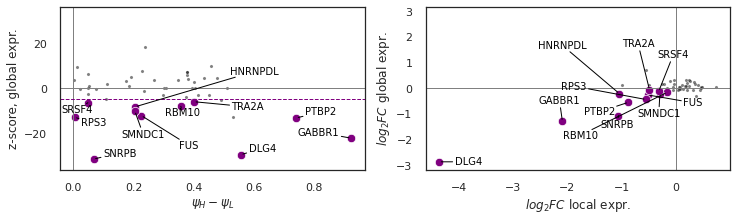

In [3362]:
font_size=10

x_features = ['psi_H_L','log2FC_local']
x_labels = [r'$\psi_H-\psi_L$',r'$log_2FC$ local expr.']
y_features = ['zscore_global','log2FC_global']
y_labels = [r'z-score, global expr.',r'$log_2FC$ global expr.']

data = GTEX_summary_pooled.copy()

interesting_genes = list(data.loc[data['significant']==1]['gene_name'])
interesting_genes_up = []
test_text = data.loc[data['gene_name'].isin(interesting_genes)]
test_text_up = data.loc[data['gene_name'].isin(interesting_genes_up)]

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, len(x_features), sharey=False, sharex=False, figsize=(12,3))

for i in range(0,len(x_features)):
    temp = data.loc[(data['gene_name'].isin(interesting_genes+interesting_genes_up))]
    k=0.5
    iqr = (temp[x_features[i]].quantile(0.75)-temp[x_features[i]].quantile(0.25))
    x_max = temp[x_features[i]].max()+iqr*k
    x_min = temp[x_features[i]].min()-iqr*k
    iqr = (temp[y_features[i]].quantile(0.75)-temp[y_features[i]].quantile(0.25))
    y_max = temp[y_features[i]].max()+iqr*k
    y_min = temp[y_features[i]].min()-iqr*k
    y_thr = max(abs(y_min),abs(y_max))
    ax = sns.scatterplot(ax=axes[i],data=data.loc[(data['significant']==0)],x=x_features[i],y=y_features[i],alpha=0.5,s=10,color='black')
    ax = sns.scatterplot(ax=axes[i],data=data.loc[(data['significant']==1)&(~data['gene_name'].isin(interesting_genes+interesting_genes_up))],
                         x=x_features[i],y=y_features[i],alpha=0.7,s=20,color='purple')
    ax = sns.scatterplot(ax=axes[i],data=test_text,x=x_features[i],y=y_features[i],alpha=1,s=70,color='purple')
    ax = sns.scatterplot(ax=axes[i],data=test_text_up,x=x_features[i],y=y_features[i],alpha=1,s=70,color='magenta')    
    
    ax.axvline(0,color='grey',lw=1)
    ax.axhline(0,color='grey',lw=1)
    if y_features[i]=='zscore_global':
        ax.axhline(-5,color='purple',lw=1,ls='--')
    ax.set(xlabel=x_labels[i],ylabel=y_labels[i],title='',ylim=(-y_thr,y_thr))
    

    
    texts = []
    for index, row in test_text.iterrows():
        texts.append(ax.text(row[x_features[i]],row[y_features[i]],row['gene_name'],ha='center',va='bottom',color='black',size=font_size))
    for index, row in test_text_up.iterrows():
        texts.append(ax.text(row[x_features[i]],row[y_features[i]],row['gene_name'],ha='center',va='bottom',color='black',size=font_size))    
    if i==0:
        autoalign='xy'
        k_x = 1.5
        k_y = 1.12
        fp_x = 1.1
        fp_y = 1.6
    else:
        autoalign=False
        k_x = 1.1
        k_y = 1.1
        fp_x = 2
        fp_y = 2.4
    %time adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),autoalign=autoalign,force_points=(fp_x,fp_y),lim=80,expand_text=(k_x,k_y),expand_points=(k_x,k_y),ax=ax,x=list(data[x_features[i]]),y=list(data[y_features[i]]))
#     force_points=(k_x,k_y),force_text=(k_x,k_y),force_objects=(k_x,k_y)
fig.savefig('./Figures/literature_all_classes_scatter_main.png',bbox_inches='tight',dpi=300)
fig

# Checking background association of $\psi$ and expression in protein-coding AS events 

In [219]:
# protein-coding cassette exons
coding_ce = pd.read_csv('./novel_events_catalog/hg19_cassette_exons_coding.tsv',delimiter="\t",
                                   index_col=None,header=0)
coding_sample = coding_ce.copy()
coding_sample['AS event position'] = coding_sample['chr']+'_'+coding_sample['upst_junction']+'_'+coding_sample['downst_junction']+'_'+coding_sample['str']
coding_sample['skip_junction'] = coding_sample['chr']+'_'+coding_sample['skip_junction']+'_'+coding_sample['str']
coding_sample['upst_junction'] = coding_sample['chr']+'_'+coding_sample['upst_junction']+'_'+coding_sample['str']
coding_sample['downst_junction'] = coding_sample['chr']+'_'+coding_sample['downst_junction']+'_'+coding_sample['str']
coding_sample['NMD_skip_junction'] = coding_sample['skip_junction']
coding_sample.rename(columns={'gene_name':'Target'},inplace=True)
coding_sample = coding_sample.drop_duplicates(['Target','AS event position'])

In [220]:
len(coding_sample)

13292

In [263]:
NMD_cols = ['NMD_skip_junction']
can_cols = ['upst_junction','downst_junction']

temp_df = coding_sample.sample(3000)
temp_summary_list,temp_sample_data_list = aaf.get_GTEX_summary_pooled(temp_df,NMD_cols,can_cols,True)

no expression for RIPOR1
no expression for SINHCAF
no expression for H2AZ2
no expression for GRAMD2B
no expression for TMEM272
no expression for C2orf92
no expression for NME1-NME2
no expression for IHO1
no expression for TMEM273
no expression for ENTR1
no expression for VPS26C
no expression for CYRIB
no expression for BABAM2
no expression for ILRUN
no expression for FXYD6-FXYD2
no expression for CARS1
no expression for RBIS
no expression for POGLUT3
no expression for COA8
no expression for HARS1
no expression for CYBC1
no expression for CEP43
no expression for SEPTIN2
no expression for ASDURF
no expression for DNAAF6
no expression for MYG1
no expression for HDGFL2
no expression for ARSL
no expression for RO60
no expression for CFAP299
no expression for AARS1
no expression for TUT7
no expression for VPS35L
no expression for EIPR1
no expression for SLC66A1
no expression for ZNF875
no expression for ELP1
no expression for SLC66A3
no expression for PTGES3L-AARSD1
no expression for ADA2
no

In [264]:
temp_sample_data = pd.concat(temp_sample_data_list).reset_index(drop=True)
temp_sample_data['index_event'] = temp_sample_data['gene_name']+'_'+temp_sample_data['AS_event_position']
temp_sample_data = temp_sample_data.drop(['gene_name','AS_event_position'],1)

# so that psi would reflect the inclusion of the cassette exon
temp_sample_data['psi'] = 1-temp_sample_data['psi']

temp_sample_data['psi_cat'] = pd.cut(temp_sample_data['psi'],bins=int(1/0.05))

In [272]:
arr = np.array(pd.Series(range(1,21))/20)
temp_sample_data['psi_cat_num'] = arr.searchsorted(temp_sample_data['psi'])
gr = temp_sample_data.groupby('psi_cat_num').agg({'global_expr':median,'local_expr':median}).reset_index()
gr['const']=1
gr['psi_center'] = 0.025+gr['psi_cat_num']*0.05

In [ ]:
os.system('mkdir -p ./Figures')

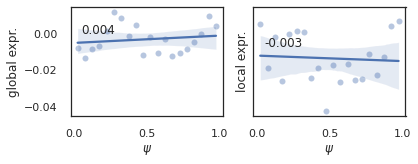

In [274]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2))

mod = sm.OLS(gr['global_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[0],data=gr,x='psi_center',y='global_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='global expr.')

mod = sm.OLS(gr['local_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[1],data=gr,x='psi_center',y='local_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='local expr.')

fig.savefig('./Figures/CE_psi_vs_expr_model.png',bbox_inches='tight',dpi=300)
# Figure SF3

In [233]:
# protein-coding alternative splice sites
hg19_alt_starts_coding = pd.read_csv('./novel_events_catalog/hg19_alt_starts_coding.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_alt_ends_coding = pd.read_csv('./novel_events_catalog/hg19_alt_ends_coding.tsv',delimiter="\t",
                                   index_col=None,header=0)

hg19_alt_starts_coding.rename(columns={'gene_name':'Target'},inplace=True)
hg19_alt_ends_coding.rename(columns={'gene_name':'Target'},inplace=True)

hg19_alt_starts_coding['AS event position'] = hg19_alt_starts_coding['chr']+'_'+hg19_alt_starts_coding['flank_exon_start'].astype('str')+\
'_'+hg19_alt_starts_coding['flank_exon_end'].astype('str')+'_'+hg19_alt_starts_coding['min_exon_start'].astype('str')+\
'_'+hg19_alt_starts_coding['max_exon_start'].astype('str')+'_'+hg19_alt_starts_coding['exon_end'].astype('str')+'_'+hg19_alt_starts_coding['str']

hg19_alt_ends_coding['AS event position'] = hg19_alt_ends_coding['chr']+'_'+hg19_alt_ends_coding['exon_start'].astype('str')+\
'_'+hg19_alt_ends_coding['min_exon_end'].astype('str')+'_'+hg19_alt_ends_coding['max_exon_end'].astype('str')+\
'_'+hg19_alt_ends_coding['flank_exon_start'].astype('str')+'_'+hg19_alt_ends_coding['flank_exon_end'].astype('str')+'_'+hg19_alt_ends_coding['str']

hg19_alt_starts_coding = hg19_alt_starts_coding.drop_duplicates(['Target','AS event position'])
hg19_alt_ends_coding = hg19_alt_ends_coding.drop_duplicates(['Target','AS event position'])

hg19_alt_starts_coding['DA_type'] = (hg19_alt_starts_coding['str']=='+').astype('int').astype('str').str.replace('1','A').replace('0','D')
hg19_alt_ends_coding['DA_type'] = (hg19_alt_ends_coding['str']=='+').astype('int').astype('str').str.replace('1','D').replace('0','A')

acc1 = hg19_alt_starts_coding.loc[hg19_alt_starts_coding['DA_type']=='A'].reset_index(drop=True)
acc2 = hg19_alt_ends_coding.loc[hg19_alt_ends_coding['DA_type']=='A'].reset_index(drop=True)

don1 = hg19_alt_starts_coding.loc[hg19_alt_starts_coding['DA_type']=='D'].reset_index(drop=True)
don2 = hg19_alt_ends_coding.loc[hg19_alt_ends_coding['DA_type']=='D'].reset_index(drop=True)

acc1['NMD_junction'] = acc1['chr']+'_'+acc1['flank_exon_end'].astype('str')+'_'+acc1['min_exon_start'].astype('str')+'_'+acc1['str']
acc1['coding_junction'] = acc1['chr']+'_'+acc1['flank_exon_end'].astype('str')+'_'+acc1['max_exon_start'].astype('str')+'_'+acc1['str']

acc2['NMD_junction'] = acc2['chr']+'_'+acc2['max_exon_end'].astype('str')+'_'+acc2['flank_exon_start'].astype('str')+'_'+acc2['str']
acc2['coding_junction'] = acc2['chr']+'_'+acc2['min_exon_end'].astype('str')+'_'+acc2['flank_exon_start'].astype('str')+'_'+acc2['str']

don1['NMD_junction'] = don1['chr']+'_'+don1['flank_exon_end'].astype('str')+'_'+don1['min_exon_start'].astype('str')+'_'+don1['str']
don1['coding_junction'] = don1['chr']+'_'+don1['flank_exon_end'].astype('str')+'_'+don1['max_exon_start'].astype('str')+'_'+don1['str']

don2['NMD_junction'] = don2['chr']+'_'+don2['max_exon_end'].astype('str')+'_'+don2['flank_exon_start'].astype('str')+'_'+don2['str']
don2['coding_junction'] = don2['chr']+'_'+don2['min_exon_end'].astype('str')+'_'+don2['flank_exon_start'].astype('str')+'_'+don2['str']

In [234]:
NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']
           
acc1_summary,acc1_data_list = aaf.get_GTEX_summary_pooled(acc1.sample(500),NMD_cols,can_cols,True)
acc2_summary,acc2_data_list = aaf.get_GTEX_summary_pooled(acc2.sample(500),NMD_cols,can_cols,True)
don1_summary,don1_data_list = aaf.get_GTEX_summary_pooled(don1.sample(500),NMD_cols,can_cols,True)
don2_summary,don2_data_list = aaf.get_GTEX_summary_pooled(don2.sample(500),NMD_cols,can_cols,True)

no expression for KIFBP
no expression for CALHM4
no expression for ZNF875
no expression for FCSK
no expression for KIRREL1
no expression for SHFL
no expression for IRAG2
no expression for PRXL2B
no expression for NFILZ
no expression for RMC1
no expression for TMEM131L
no expression for DOP1A
no expression for GUCY1B1
no expression for AC011479.1
no expression for HROB
no expression for REX1BD
done: 0 out of 500
LQ or UQ are zero length: ACSBG2 chr19_6141524_6141621_6147457_6147467_6147686_+
LQ or UQ are zero length: ADAD1 chr4_123329063_123329186_123332377_123332410_123332547_+
LQ or UQ are zero length: ADGRB1 chr8_143558746_143558910_143559548_143559557_143559721_+
LQ or UQ are zero length: ADGRG1 chr16_57684165_57684263_57685097_57685112_57685534_+
LQ or UQ are zero length: ADGRL2 chr1_82408653_82409453_82415873_82416071_82416166_+
LQ or UQ are zero length: AFMID chr17_76187051_76187141_76193216_76193227_76193641_+
LQ or UQ are zero length: AGFG1 chr2_228398265_228398474_228399561_22

In [235]:
temp_sample_data = pd.concat(acc1_data_list+acc2_data_list).reset_index(drop=True)
temp_sample_data['index_event'] = temp_sample_data['gene_name']+'_'+temp_sample_data['AS_event_position']
temp_sample_data = temp_sample_data.drop(['gene_name','AS_event_position'],1)
temp_sample_data['psi_cat'] = pd.cut(temp_sample_data['psi'],bins=int(1/0.05))

In [238]:
arr = np.array(pd.Series(range(1,21))/20)
temp_sample_data['psi_cat_num'] = arr.searchsorted(temp_sample_data['psi'])
gr = temp_sample_data.groupby('psi_cat_num').agg({'global_expr':median,'local_expr':median}).reset_index()
gr['const']=1
gr['psi_center'] = 0.025+gr['psi_cat_num']*0.05

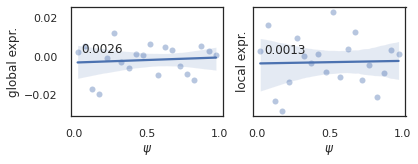

In [240]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2))

mod = sm.OLS(gr['global_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[0],data=gr,x='psi_center',y='global_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='global expr.')

mod = sm.OLS(gr['local_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[1],data=gr,x='psi_center',y='local_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='local expr.')

fig.savefig('./Figures/ACC_psi_vs_expr_model.png',bbox_inches='tight',dpi=300)
# Figure SF3

In [241]:
temp_sample_data = pd.concat(don1_data_list+don2_data_list).reset_index(drop=True)
temp_sample_data['index_event'] = temp_sample_data['gene_name']+'_'+temp_sample_data['AS_event_position']
temp_sample_data = temp_sample_data.drop(['gene_name','AS_event_position'],1)
temp_sample_data['psi_cat'] = pd.cut(temp_sample_data['psi'],bins=int(1/0.05))

In [244]:
arr = np.array(pd.Series(range(1,21))/20)
temp_sample_data['psi_cat_num'] = arr.searchsorted(temp_sample_data['psi'])
gr = temp_sample_data.groupby('psi_cat_num').agg({'global_expr':median,'local_expr':median}).reset_index()
gr['const']=1
gr['psi_center'] = 0.025+gr['psi_cat_num']*0.05

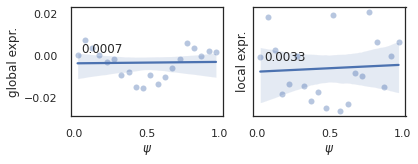

In [246]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2))

mod = sm.OLS(gr['global_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[0],data=gr,x='psi_center',y='global_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='global expr.')

mod = sm.OLS(gr['local_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[1],data=gr,x='psi_center',y='local_expr',scatter_kws={'alpha':0.4})
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='local expr.')

fig.savefig('./Figures/DON_psi_vs_expr_model.png',bbox_inches='tight',dpi=300)

In [168]:
# protein-coding intron retention
hg19_intron_retention_coding = pd.read_csv('./novel_events_catalog/hg19_intron_retention_coding.tsv',delimiter="\t",
                                   index_col=None,header=0)
hg19_intron_retention_coding.rename(columns={'gene_name':'Target'},inplace=True)
hg19_intron_retention_coding['AS event position'] = hg19_intron_retention_coding['chr']+'_'+hg19_intron_retention_coding['upst_exon_start'].astype('str')+'_'+\
hg19_intron_retention_coding['upst_exon_end'].astype('str')+'_'+hg19_intron_retention_coding['downst_exon_start'].astype('str')+'_'+hg19_intron_retention_coding['downst_exon_end'].astype('str')+'_'+\
hg19_intron_retention_coding['str']
hg19_intron_retention_coding = hg19_intron_retention_coding.drop_duplicates(['Target','AS event position'])
hg19_intron_retention_coding['NMD_site_upst'] = hg19_intron_retention_coding['chr']+'_'+hg19_intron_retention_coding['upst_exon_end'].astype('str')+'_'+\
hg19_intron_retention_coding['str']
hg19_intron_retention_coding['NMD_site_downst'] = hg19_intron_retention_coding['chr']+'_'+hg19_intron_retention_coding['downst_exon_start'].astype('str')+'_'+\
hg19_intron_retention_coding['str']
hg19_intron_retention_coding['coding_junction'] = hg19_intron_retention_coding['chr']+'_'+hg19_intron_retention_coding['upst_exon_end'].astype('str')+'_'+\
hg19_intron_retention_coding['downst_exon_start'].astype('str')+'_'+hg19_intron_retention_coding['str']

In [170]:
NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']
           
ir_summary,ir_data_list = aaf.get_GTEX_summary_pooled(hg19_intron_retention_coding,NMD_cols,can_cols,True)

no expression for NEXMIF
no expression for MUCL3
no expression for SEPTIN4
no expression for ZSWIM9
no expression for KHDC4
no expression for ATP5F1D
no expression for GATD3A
no expression for EOLA1
no expression for AL391650.1
no expression for CFAP298
no expression for PIP4P1
no expression for CIAO2B
no expression for HEXD
no expression for CCNP
no expression for IQCN
no expression for CYRIB
no expression for TSBP1
no expression for H2BW2
LQ or UQ are zero length: ABCA8 chr17_66917523_66917591_66917593_66917633_-
LQ or UQ are zero length: ABCA8 chr17_66925190_66925251_66925319_66925375_-
LQ or UQ are zero length: ABHD14B chr3_52005476_52005714_52005828_52005908_-
LQ or UQ are zero length: ACAN chr15_89398083_89398752_89398810_89402648_+
LQ or UQ are zero length: ACRV1 chr11_125547692_125547913_125548124_125548192_-
LQ or UQ are zero length: ACRV1 chr11_125547692_125547958_125548124_125548192_-
LQ or UQ are zero length: ADAR chr1_154573517_154574724_154574861_154575102_-
LQ or UQ are 

In [171]:
temp_sample_data = pd.concat(ir_data_list).reset_index(drop=True)
temp_sample_data['index_event'] = temp_sample_data['gene_name']+'_'+temp_sample_data['AS_event_position']
temp_sample_data = temp_sample_data.drop(['gene_name','AS_event_position'],1)

In [172]:
arr = np.array(pd.Series(range(1,21))/20)
temp_sample_data['psi_cat_num'] = arr.searchsorted(temp_sample_data['psi'])
gr = temp_sample_data.groupby('psi_cat_num').agg({'global_expr':median,'local_expr':median}).reset_index()
gr['const']=1
gr['psi_center'] = 0.025+gr['psi_cat_num']*0.05

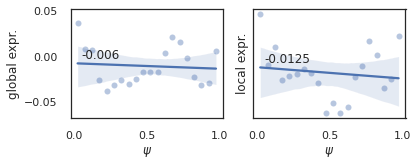

In [218]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2))

mod = sm.OLS(gr['global_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[0],data=gr,x='psi_center',y='global_expr',scatter_kws={'alpha':0.4})
# ax.axhline(0,color='grey',lw=0.5,ls='--')
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='global expr.')

mod = sm.OLS(gr['local_expr'].values, gr[['const','psi_center']].values)
res = mod.fit()
res.params[1]

ax = sns.regplot(ax=axes[1],data=gr,x='psi_center',y='local_expr',scatter_kws={'alpha':0.4})
# ax.axhline(0,color='grey',lw=0.5,ls='--')
ax.text(x=0.05,y=res.params[0]+0.005,s=str(np.round(res.params[1],4)))
ax.set(xlabel=r'$\psi$',ylabel='local expr.')

fig.savefig('./Figures/IR_psi_vs_expr_model.png',bbox_inches='tight',dpi=300)

# We now apply the threshold to all USEs to identify significant ones 

In [94]:
as_classes = ['poison exon','essential exon',
               "poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site",
              'intron retention','intron detention']
coding_sample_path = ['hg19_coding_CE_skip_summary_2','hg19_coding_CE_skip_summary_2',
                      'hg19_coding_donor_summary_2','hg19_coding_donor_summary_2','hg19_coding_acceptor_summary_2','hg19_coding_acceptor_summary_2',
                      'hg19_coding_ir_summary','hg19_coding_ir_summary']
nmd_sample_path = ['hg19_poison_exons_summary','hg19_essential_exons_summary',
                   'hg19_poison_donor_summary','hg19_essential_donor_summary','hg19_poison_acceptor_summary','hg19_essential_acceptor_summary',
                  'hg19_intron_retention_summary','hg19_intron_detention_summary']

zscore_global_thr = 5
zscore_local_thr = 0
psi_H_L_thr = 0
log2FC_global_thr = 0
log2FC_local_thr = 0

font_size=10

x_features = ['psi_H_L','zscore_global','psi_H_L','zscore_local']
x_labels = [r'$\psi_H-\psi_L$',r'z-score',r'$\psi_H-\psi_L$',r'z-score']
y_features = ['log2FC_global','log2FC_global','log2FC_local','log2FC_local']
titles = ['global expr.','global expr.','local expr.','local expr.']

k=0
a = []
a_control = []
b = []
b_control = []
for as_class in as_classes:
    
    coding_sample = pd.read_csv('./novel_events_catalog/'+coding_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)
    
    coding_sample['zscore_global'] = coding_sample['zscore_global']*(-1)
    coding_sample['zscore_local'] = coding_sample['zscore_local']*(-1)
    
    coding_sample['psi_H_L'] = coding_sample['psi_H']-coding_sample['psi_L']
    coding_sample = coding_sample.loc[(coding_sample['psi_H_L']>0)&(coding_sample['psi_H_L']<1)]
    coding_sample = coding_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)

    control = coding_sample.copy()
    if as_class in ['poison exon','intron detention',"essential 5' splice site","essential 3' splice site"]: 
        control['psi_H'] = 1-control['psi_H']
        control['psi_L'] = 1-control['psi_L']
        control['psi_H_L'] = control['psi_L']-control['psi_H']
        control['log2FC_global'] = control['log2FC_global']*(-1)
        control['log2FC_local'] = control['log2FC_local']*(-1)
        control['zscore_global'] = control['zscore_global']*(-1)
        control['zscore_local'] = control['zscore_local']*(-1)
    control['group'] = 'coding'
    control['co'] = control.apply(lambda x: get_co_gtex(x),1)
    control['stop_rel_position'] = ''
    
    nmd_sample = pd.read_csv('./novel_events_catalog/summaries/'+nmd_sample_path[k]+'.tsv',delimiter="\t",
                                       index_col=None,header=0)

    nmd_sample['zscore_global'] = nmd_sample['zscore_global']*(-1)
    nmd_sample['zscore_local'] = nmd_sample['zscore_local']*(-1)

    nmd_sample['psi_H_L'] = nmd_sample['psi_H']-nmd_sample['psi_L']
    nmd_sample = nmd_sample.sort_values('psi_H_L',ascending=True).reset_index(drop=True)
    
    # we merge annotated USEs with validated ones and take care of duplicates by comparing their psi_H and psi_L values
    nmd_sample['psi_H_temp'] = np.round(nmd_sample['psi_H'],2)
    nmd_sample['psi_L_temp'] = np.round(nmd_sample['psi_L'],2)
    GTEX_summary_pooled_sample = GTEX_summary_pooled.loc[GTEX_summary_pooled['AS type']==as_class].drop('AS type',1)
    GTEX_summary_pooled_sample['psi_H_temp'] = np.round(GTEX_summary_pooled_sample['psi_H'],2)
    GTEX_summary_pooled_sample['psi_L_temp'] = np.round(GTEX_summary_pooled_sample['psi_L'],2)
    GTEX_summary_pooled_sample['lit']=1
    nmd_sample = pd.merge(nmd_sample,GTEX_summary_pooled_sample[['gene_name','psi_H_temp','psi_L_temp','lit']],how='left',
    on=['gene_name','psi_H_temp','psi_L_temp'])
    nmd_sample = nmd_sample.loc[nmd_sample['lit'].isna()].drop(['psi_H_temp','psi_L_temp','lit'],1).drop_duplicates()
    GTEX_summary_pooled_sample = GTEX_summary_pooled_sample.drop(['psi_H_temp','psi_L_temp'],1)
    nmd_sample['lit']=0
    nmd_sample = pd.concat([nmd_sample,GTEX_summary_pooled_sample]).reset_index(drop=True)
    
    
    nmd_sample['co'] = nmd_sample.apply(lambda x: get_co_gtex(x),1)
    
    test = nmd_sample.copy()
    test['group'] = 'nmd'
    
    data = pd.concat([test[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 
                            'zscore_global', 'zscore_local','co','group','stop_rel_position']],
        control[['gene_name', 'AS event position','psi_H_L','log2FC_global','log2FC_local', 
                 'zscore_global', 'zscore_local','co','group','stop_rel_position']]]).reset_index(drop=True)
    
    data = data.drop_duplicates(['gene_name','AS event position']).reset_index(drop=True)
    
    data['significant'] = ((data['co']==-1).astype('int'))*(
        abs(data['zscore_global'])>zscore_global_thr).astype('int')*(
        data['psi_H_L']>psi_H_L_thr).astype('int')*(abs(data['log2FC_global'])>log2FC_global_thr).astype('int')*(
        abs(data['zscore_local'])>zscore_local_thr).astype('int')*(
        abs(data['log2FC_local'])>log2FC_local_thr).astype('int')
    
    res = data.loc[(data['group']=='nmd')&(data['significant']==1)]
    res['as_class'] = as_class
    a.append(res)
    res = data.loc[(data['group']=='nmd')]
    res['as_class'] = as_class    
    a_control.append(res)

    res = data.loc[(data['group']=='coding')&(data['significant']==1)]
    res['as_class'] = as_class
    b.append(res)
    res = data.loc[(data['group']=='coding')]
    res['as_class'] = as_class    
    b_control.append(res)
        
    k=k+1

In [95]:
GTEX_summary_pooled['index_event'] = GTEX_summary_pooled['gene_name']+'_'+GTEX_summary_pooled['AS event position']
temp = pd.merge(pd.concat(a_control),GTEX_summary_pooled[['gene_name','AS event position']],how='right',on=['gene_name','AS event position'])
nmd_gtex_res = pd.concat(a_control)

In [126]:
# events in SRSF11 and U2AF1 were missed
temp = GTEX_summary_pooled.loc[GTEX_summary_pooled['gene_name'].isin(['SRSF11','U2AF1'])][
    ['AS type','gene_name', 'AS event position','stop_rel_position', 'psi_H_L', 'log2FC_global',
       'log2FC_local', 'zscore_global', 'zscore_local']
]
temp['co']=temp.apply(lambda x: get_co_gtex(x),1)
temp['group']='nmd'
temp['significant']=((temp['co']==-1).astype('int'))*(
        abs(temp['zscore_global'])>zscore_global_thr).astype('int')*(
        temp['psi_H_L']>psi_H_L_thr).astype('int')*(abs(temp['log2FC_global'])>log2FC_global_thr).astype('int')*(
        abs(temp['zscore_local'])>zscore_local_thr).astype('int')*(
        abs(temp['log2FC_local'])>log2FC_local_thr).astype('int')
temp['as_class'] = temp['AS type']

In [127]:
nmd_gtex_res = pd.concat([temp[list(nmd_gtex_res.columns)],nmd_gtex_res])

In [128]:
len(nmd_gtex_res)

2879

In [134]:
nmd_gtex_res['index_event'] = nmd_gtex_res['gene_name']+'_'+nmd_gtex_res['AS event position']

In [ ]:
os.system('mkdir -p ./novel_events_catalog/analysis_results/')

In [135]:
nmd_gtex_res.to_csv('./novel_events_catalog/analysis_results/significant_gtex_spli_vs_expr.tsv', sep=str('\t'),header=True,index=None)

# We identify tissue-specific among significant USEs

In [2663]:
targets = nmd_gtex_res.loc[nmd_gtex_res['significant']==1].drop('t',1).reset_index(drop=True)
targets['index_event'] = targets['gene_name']+'_'+targets['AS event position']

In [2665]:
ts_analysis_res = []

In [2666]:
# poison exons
as_class = 'poison exon'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])
summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 249
done: 20 out of 249
done: 40 out of 249
done: 60 out of 249
done: 80 out of 249
done: 100 out of 249
done: 120 out of 249
done: 140 out of 249
done: 160 out of 249
done: 180 out of 249
done: 200 out of 249
done: 220 out of 249
done: 240 out of 249
0 out of 249
20 out of 249
40 out of 249
60 out of 249
80 out of 249
100 out of 249
120 out of 249
140 out of 249
160 out of 249
180 out of 249
200 out of 249
220 out of 249
240 out of 249


In [2667]:
# essential exons
as_class = 'essential exon'
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 174
done: 20 out of 174
done: 40 out of 174
done: 60 out of 174
done: 80 out of 174
done: 100 out of 174
done: 120 out of 174
done: 140 out of 174
done: 160 out of 174
0 out of 174
20 out of 174
40 out of 174
60 out of 174
80 out of 174
100 out of 174
120 out of 174
140 out of 174
160 out of 174


In [2668]:
# alt starts
targeted_as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 64
done: 20 out of 64
done: 40 out of 64
done: 60 out of 64
0 out of 64
20 out of 64
40 out of 64
60 out of 64


In [2669]:
# alt ends
targeted_as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 60
done: 20 out of 60
done: 40 out of 60
0 out of 60
20 out of 60
40 out of 60


In [2670]:
# intron retention
targeted_as_classes = ['intron retention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 19
0 out of 19


In [2671]:
# intron detention
targeted_as_classes = ['intron detention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
ts_res = aaf.get_ts_res(nmd_sample_data)
ts_analysis_res.append(ts_res)

done: 0 out of 8
0 out of 8


In [2672]:
ts_analysis_res = pd.concat(ts_analysis_res)
ts_analysis_res = ts_analysis_res.reset_index(drop=True)

In [495]:
# we add validated USEs
summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(leus_df,NMD_cols,can_cols,True)
nmd_sample_data = pd.concat(nmd_sample_data).reset_index(drop=True)
ts_analysis_res_literature = aaf.get_ts_res(nmd_sample_data)

done: 0 out of 58
no expression for: CCN1 intron 3
done: 20 out of 58
done: 40 out of 58
0 out of 54
20 out of 54
40 out of 54


In [531]:
ts_analysis_res['lit']=0
ts_analysis_res_literature['lit']=1

In [533]:
# non-significant USEs should not be considered
ts_analysis_res_literature = pd.merge(ts_analysis_res_literature,nmd_gtex_res.loc[nmd_gtex_res['significant']==1][['index_event']].drop_duplicates(),
how='inner',on=['index_event'])

In [534]:
ts_analysis_res = pd.concat([ts_analysis_res,ts_analysis_res_literature]).reset_index(drop=True)

ts_analysis_res['delta_psi'] = ts_analysis_res['psi']-ts_analysis_res['psi_med']
ts_analysis_res[['delta_psi','global_expr','local_expr']] = ts_analysis_res[['delta_psi','global_expr','local_expr']].fillna(0)
ts_analysis_res[['psi_fdr','global_expr_fdr','local_expr_fdr']] = ts_analysis_res[['psi_fdr','global_expr_fdr','local_expr_fdr']].fillna(1)

ts_analysis_res['global_expr'] = ts_analysis_res['global_expr']-ts_analysis_res['global_expr_med']
ts_analysis_res['local_expr'] = ts_analysis_res['local_expr']-ts_analysis_res['local_expr_med']

ts_analysis_res['DS'] = (abs(ts_analysis_res['delta_psi'])>0.05).astype('int')*(ts_analysis_res['psi_fdr']<0.05).astype('int')*((ts_analysis_res['delta_psi']>0).astype('int')*2-1)
ts_analysis_res['DE_global'] = (ts_analysis_res['global_expr_fdr']<0.05).astype('int')*((ts_analysis_res['global_expr']>0).astype('int')*2-1)
ts_analysis_res['DE_local'] = (ts_analysis_res['local_expr_fdr']<0.05).astype('int')*((ts_analysis_res['local_expr']>0).astype('int')*2-1)
ts_analysis_res['co_global'] = ts_analysis_res['DS']*ts_analysis_res['DE_global']*(-1)
ts_analysis_res['co_local'] = ts_analysis_res['DS']*ts_analysis_res['DE_local']*(-1)

def get_co(x):
    if x['co_local']==-1 and x['co_global']==-1:
        return -1
    elif x['co_local']==1 and x['co_global']==1:
        return 1
    else:
        return 0

ts_analysis_res['co'] = ts_analysis_res.apply(lambda x:get_co(x),1)

In [537]:
ts_analysis_res['t']=1
tmp1 = pd.DataFrame(ts_analysis_res['index_event'].unique(),columns=['index_event'])
tmp1 = pd.merge(tmp1,
ts_analysis_res.loc[ts_analysis_res['co']==1].groupby('index_event').agg({'t':sum}).reset_index().rename(columns={'t':'# co'}),
how='left',on='index_event')
tmp1 = pd.merge(tmp1,
ts_analysis_res.loc[ts_analysis_res['co']==-1].groupby('index_event').agg({'t':sum}).reset_index().rename(columns={'t':'# anti'}),
how='left',on='index_event')
tmp1 = pd.merge(tmp1,
ts_analysis_res.loc[ts_analysis_res['co']==0].groupby('index_event').agg({'t':sum}).reset_index().rename(columns={'t':'# NS'}),
how='left',on='index_event')

In [538]:
tmp1[['# co','# anti','# NS']] = tmp1[['# co','# anti','# NS']].fillna(0).astype('int')

In [539]:
def get_co_anti_pval(x):
    m = x['# co']
    n = x['# co']+x['# anti']
    if n>0:
        return stats.binom_test(m,n,alternative='greater')
    else:
        return 1
tmp1['pval'] = tmp1.apply(lambda x:get_co_anti_pval(x),1)

In [546]:
tmp1['fdr'] = multipletests(tmp1['pval'],method='fdr_bh')[1]
tmp1['TS'] = (tmp1['fdr']<0.1).astype('int')

In [566]:
ts_analysis_res['DS_abs'] = abs(ts_analysis_res['DS'])
ts_analysis_res['DE_global_abs'] = abs(ts_analysis_res['DE_global'])
ts_analysis_res['DE_local_abs'] = abs(ts_analysis_res['DE_local'])
gr_ts_analysis = ts_analysis_res.groupby('index_event').agg({'DS_abs':max,'DE_global_abs':max,'DE_local_abs':max}).reset_index()
gr_ts_analysis = pd.merge(gr_ts_analysis,tmp1,how='left',on='index_event')

In [569]:
gr_ts_analysis = pd.merge(gr_ts_analysis,nmd_gtex_res[['index_event','as_class','stop_rel_position']].drop_duplicates(),how='left',on=['index_event'])

In [1031]:
# Significant validated USEs classified as tissue-specific (TS) or not
gr_ts_analysis.loc[~gr_ts_analysis['index_event'].str.contains('chr')]

,index_event,DS_abs,DE_global_abs,DE_local_abs,# co,# anti,# NS,pval,fdr,TS,as_class,stop_rel_position
127,DLG4_exon 17,1,1,1,21,1,28,0.000005,0.000397,1,essential exon,stop_downstream
169,FUS_exon 7,1,1,1,3,2,45,0.500000,1.000000,0,essential exon,stop_downstream
173,GABBR1_exon 15,1,1,1,11,0,39,0.000488,0.007440,1,essential exon,stop_downstream
201,HNRNPDL_3'UTR,1,1,1,1,1,48,0.750000,1.000000,0,poison exon,stop_upstream
367,PTBP2_exon 10,1,1,1,17,1,32,0.000072,0.002209,1,essential exon,stop_downstream
380,RBM10_exon 6,1,1,1,10,1,39,0.005859,0.055616,1,essential exon,stop_downstream
412,RPS3_exon 2,0,1,1,0,0,50,1.000000,1.000000,0,poison 5' splice site,stop_downstream
455,SMNDC1_exon 3a,1,1,1,2,4,44,0.890625,1.000000,0,poison exon,stop_downstream
458,SNRPB_exon 3a,1,1,1,8,0,42,0.003906,0.037695,1,poison exon,stop_within
467,SRSF4_exon 3a,1,1,1,1,0,49,0.500000,1.000000,0,poison exon,stop_downstream


In [574]:
ts_analysis_res.to_csv('./novel_events_catalog/analysis_results/ts_gtex_spli_vs_expr.tsv', sep=str('\t'),header=True,index=None)

In [1348]:
gr_ts_analysis.to_csv('./novel_events_catalog/analysis_results/ts_gtex_spli_vs_expr_grouped.tsv', sep=str('\t'),header=True,index=None)

# Abundance of USEs in particular tissues

In [125]:
def mofidy_protDB_tissues(s):
    sn = s
    if sn == 'cerebral cortex':
        sn = 'brain - cortex'
    elif sn == 'prostate gland':
        sn = 'prostate'
    elif sn == 'thyroid gland':
        sn = 'thyroid'
    elif sn == 'urinary bladder':
        sn = 'bladder'
    elif sn == 'uterine cervix':
        sn = 'cervix'
    elif sn == 'spinal cord':
        sn = 'brain - spinal cord'
    return sn

def mofidy_GTEx_tissues(s):
    sn = s
    if sn == 'Adipose - Visceral (Omentum)':
        sn = 'Adipose - Visceral'
    elif sn == 'Brain - Caudate (basal ganglia)':
        sn = 'Brain - Caudate'
    elif sn == 'Brain - Frontal Cortex (BA9)':
        sn = 'Brain - Frontal Cortex'
    elif sn == 'Brain - Anterior cingulate cortex (BA24)':
        sn = 'Brain - Anterior cingulate cortex'
    elif sn == 'Brain - Nucleus accumbens (basal ganglia)':
        sn = 'Brain - Nucleus accumbens'
    elif sn == 'Brain - Putamen (basal ganglia)':
        sn = 'Brain - Putamen'
    elif sn == 'Brain - Spinal cord (cervical c-1)':
        sn = 'Brain - Spinal cord'
    elif sn == 'Breast - Mammary Tissue':
        sn = 'Breast'
    elif sn == 'Skin - Not Sun Exposed (Suprapubic)':
        sn = 'Skin - Not Sun Exposed'
    elif sn == 'Skin - Sun Exposed (Lower leg)':
        sn = 'Skin - Sun Exposed'
    elif sn == 'Whole Blood':
        sn = 'Blood'
    return sn

In [176]:
ts_analysis_res['n']=1
tmp1 = ts_analysis_res.groupby(['smtsd']).agg({'n':sum}).reset_index()
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DS']==1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'up'}),
         how='left',on='smtsd')
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DS']==-1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'down'}),
         how='left',on='smtsd')
tmp1[['up','down']] = tmp1[['up','down']].fillna(0).astype('int')
tmp1['% up'] = np.round(tmp1['up']/tmp1['n']*100,1)
tmp1['% down'] = np.round(tmp1['down']/tmp1['n']*100,1)

GTEX_color_codes = pd.read_csv('./misc/GTEX_color_codes.tsv',delimiter="\t",index_col=None,header=0)
GTEX_color_codes.rename(columns={'SMTSD':'smtsd'},inplace=True)
tmp1 = pd.merge(tmp1,GTEX_color_codes[['smtsd','color_code']],how='left',on='smtsd')

CPU times: user 6.03 s, sys: 2.26 s, total: 8.28 s
Wall time: 8.1 s


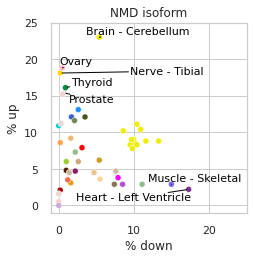

In [177]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.5,3.5))

perc_max = max(tmp1[['% down','% up']].max(1))
smtsd_to_show = ['Brain - Cerebellum','Ovary','Nerve - Tibial','Thyroid','Prostate','Heart - Left Ventricle','Muscle - Skeletal']
x_feaure = '% down'
y_feaure = '% up'

ax = sns.scatterplot(data = tmp1, y = y_feaure, x = x_feaure, hue='smtsd', palette = list(tmp1['color_code']))
ax.set(xlim=(-1,perc_max+2),ylim=(-1,perc_max+2),title='NMD isoform')
ax.legend_.remove()

test_text = tmp1.loc[tmp1['smtsd'].isin(smtsd_to_show)]
texts = []
for index, row in test_text.iterrows():
    texts.append(ax.text(row[x_feaure],
                         row[y_feaure],row['smtsd'],ha='right',va='top',color='black',size=11))

k_x=1.3
k_y=1.1
autoalign='y'
%time adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),ax=ax,autoalign=autoalign,expand_points=(k_x,k_y),expand_text=(k_x,k_y),x=list(tmp1[x_feaure]),y=list(tmp1[y_feaure]))

fig.savefig('./Figures/TS_splicing.png',bbox_inches='tight',dpi=300)
# Fig SF5,A
fig

In [161]:
ts_analysis_res['n']=1
tmp1 = ts_analysis_res.groupby(['smtsd']).agg({'n':sum}).reset_index()
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DE_global']==1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'up'}),
         how='left',on='smtsd')
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DE_global']==-1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'down'}),
         how='left',on='smtsd')
tmp1[['up','down']] = tmp1[['up','down']].fillna(0).astype('int')
tmp1['% up'] = np.round(tmp1['up']/tmp1['n']*100,1)
tmp1['% down'] = np.round(tmp1['down']/tmp1['n']*100,1)

GTEX_color_codes = pd.read_csv('./misc/GTEX_color_codes.tsv',delimiter="\t",index_col=None,header=0)
GTEX_color_codes.rename(columns={'SMTSD':'smtsd'},inplace=True)
tmp1 = pd.merge(tmp1,GTEX_color_codes[['smtsd','color_code']],how='left',on='smtsd')

CPU times: user 3.42 s, sys: 1.83 s, total: 5.25 s
Wall time: 5.07 s


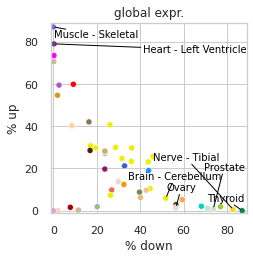

In [171]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.5,3.5))

perc_max = max(tmp1[['% down','% up']].max(1))
smtsd_to_show = ['Brain - Cerebellum','Ovary','Nerve - Tibial','Thyroid','Prostate','Heart - Left Ventricle','Muscle - Skeletal']
x_feaure = '% down'
y_feaure = '% up'

ax = sns.scatterplot(data = tmp1, y = y_feaure, x = x_feaure, hue='smtsd', palette = list(tmp1['color_code']))
ax.set(xlim=(-1,perc_max+2),ylim=(-1,perc_max+2),title='global expr.')
ax.legend_.remove()

test_text = tmp1.loc[tmp1['smtsd'].isin(smtsd_to_show)]
texts = []
for index, row in test_text.iterrows():
    texts.append(ax.text(row[x_feaure],
                         row[y_feaure],row['smtsd'],ha='right',va='top',color='black',size=10))

k_x=1.3
k_y=1.5
autoalign=False
%time adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),ax=ax,autoalign=autoalign,expand_points=(k_x,k_y),expand_text=(k_x,k_y),x=list(tmp1[x_feaure]),y=list(tmp1[y_feaure]))

fig.savefig('./Figures/TS_global_expression.png',bbox_inches='tight',dpi=300)
# Fig SF5,B,left
fig

In [172]:
ts_analysis_res['n']=1
tmp1 = ts_analysis_res.groupby(['smtsd']).agg({'n':sum}).reset_index()
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DE_local']==1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'up'}),
         how='left',on='smtsd')
tmp1 = pd.merge(tmp1,ts_analysis_res.loc[ts_analysis_res['DE_local']==-1].groupby(['smtsd']).agg({'n':sum}).reset_index().rename(columns={'n':'down'}),
         how='left',on='smtsd')
tmp1[['up','down']] = tmp1[['up','down']].fillna(0).astype('int')
tmp1['% up'] = np.round(tmp1['up']/tmp1['n']*100,1)
tmp1['% down'] = np.round(tmp1['down']/tmp1['n']*100,1)

GTEX_color_codes = pd.read_csv('./misc/GTEX_color_codes.tsv',delimiter="\t",index_col=None,header=0)
GTEX_color_codes.rename(columns={'SMTSD':'smtsd'},inplace=True)
tmp1 = pd.merge(tmp1,GTEX_color_codes[['smtsd','color_code']],how='left',on='smtsd')

CPU times: user 2.73 s, sys: 1.36 s, total: 4.09 s
Wall time: 3.91 s


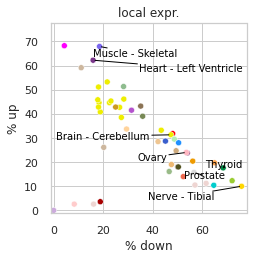

In [174]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.5,3.5))

perc_max = max(tmp1[['% down','% up']].max(1))
smtsd_to_show = ['Brain - Cerebellum','Ovary','Nerve - Tibial','Thyroid','Prostate','Heart - Left Ventricle','Muscle - Skeletal']
x_feaure = '% down'
y_feaure = '% up'

ax = sns.scatterplot(data = tmp1, y = y_feaure, x = x_feaure, hue='smtsd', palette = list(tmp1['color_code']))
ax.set(xlim=(-1,perc_max+2),ylim=(-1,perc_max+2),title='local expr.')
ax.legend_.remove()

test_text = tmp1.loc[tmp1['smtsd'].isin(smtsd_to_show)]
texts = []
for index, row in test_text.iterrows():
    texts.append(ax.text(row[x_feaure],
                         row[y_feaure],row['smtsd'],ha='right',va='top',color='black',size=10))

k_x=1.3
k_y=1.5
autoalign=False
%time adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),ax=ax,autoalign=autoalign,expand_points=(k_x,k_y),expand_text=(k_x,k_y),x=list(tmp1[x_feaure]),y=list(tmp1[y_feaure]))

fig.savefig('./Figures/TS_local_expression.png',bbox_inches='tight',dpi=300)
# Fig SF5,B,right
fig

In [ ]:
# Now we do a chi-square test for the difference between observed and expected abundance 
# of tissue-specific negative associations of psi and expression

In [178]:
ts_analysis_res['co_up'] = (ts_analysis_res['DS']==1).astype('int')*(ts_analysis_res['DE_global']==-1).astype('int')*(ts_analysis_res['DE_local']==-1).astype('int')
ts_analysis_res['co_down'] = (ts_analysis_res['DS']==-1).astype('int')*(ts_analysis_res['DE_global']==1).astype('int')*(ts_analysis_res['DE_local']==1).astype('int')

In [179]:
ts_analysis_res['n']=1
tmp1 = ts_analysis_res.groupby(['smtsd']).agg({'n':sum}).reset_index()
for feature in ['DS','DE_global','DE_local']:
    for value_var in [-1,1]:
        feature_name = feature+'_'+str(value_var).replace('-1','down').replace('1','up')
        tmp1 = pd.merge(tmp1,
                 ts_analysis_res.loc[ts_analysis_res[feature]==value_var].groupby('smtsd').agg({'t':sum}).reset_index().rename(columns={'t':feature_name}),
                 how='left',on=['smtsd'])
        tmp1[feature_name] = tmp1[feature_name].fillna(0).astype('int')
for feature in ['co_up','co_down','co']:
    tmp1 = pd.merge(tmp1,
             ts_analysis_res.groupby('smtsd').agg({feature:sum}).reset_index(),
             how='left',on=['smtsd'])
    tmp1[feature] = tmp1[feature].fillna(0).astype('int')

tmp1['% back_co_up'] = np.round((tmp1['DS_up']/tmp1['n'])*(tmp1['DE_global_down']/tmp1['n'])*(tmp1['DE_local_down']/tmp1['n'])*100,1)
tmp1['back_co_up'] = tmp1['% back_co_up']/100*tmp1['n']
tmp1['% back_co_down'] = np.round((tmp1['DS_down']/tmp1['n'])*(tmp1['DE_global_up']/tmp1['n'])*(tmp1['DE_local_up']/tmp1['n'])*100,1)
tmp1['back_co_down'] = tmp1['% back_co_down']/100*tmp1['n']
tmp1['% co_up'] = np.round(tmp1['co_up']/tmp1['n']*100,1)
tmp1['% co_down'] = np.round(tmp1['co_down']/tmp1['n']*100,1)

def get_fisher_pval(x,direction):
    return stats.fisher_exact([[x['co_'+direction],x['n']-x['co_'+direction]],
    [x['back_co_'+direction],x['n']-x['back_co_'+direction]]])[1]

tmp1['co_up_pval'] = tmp1.apply(lambda x:get_fisher_pval(x,'up'),1)
tmp1['co_down_pval'] = tmp1.apply(lambda x:get_fisher_pval(x,'down'),1)
tmp1['co_up_fdr'] = multipletests(tmp1['co_up_pval'],method='fdr_bh')[1]
tmp1['co_down_fdr'] = multipletests(tmp1['co_down_pval'],method='fdr_bh')[1]

tmp1[['% back_co_up','% back_co_down','% co_up','% co_down']] = tmp1[['% back_co_up','% back_co_down','% co_up','% co_down']].fillna(0)

In [183]:
GTEX_color_codes = pd.read_csv('./misc/GTEX_color_codes.tsv',delimiter="\t",index_col=None,header=0)
GTEX_color_codes.rename(columns={'SMTSD':'smtsd'},inplace=True)

In [184]:
tmp1 = pd.merge(tmp1,GTEX_color_codes[['smtsd','color_code']],how='left',on='smtsd')

CPU times: user 2.11 s, sys: 716 ms, total: 2.83 s
Wall time: 3.04 s
CPU times: user 1.35 s, sys: 555 ms, total: 1.9 s
Wall time: 1.73 s


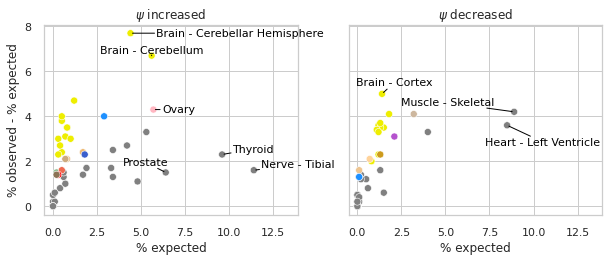

In [192]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,3.5))

titles = [r'$\psi$ increased',r'$\psi$ decreased']
smtsd_to_show = [['Brain - Cerebellum','Brain - Cerebellar Hemisphere','Ovary','Nerve - Tibial','Thyroid','Prostate'],
                 ['Brain - Cortex','Muscle - Skeletal','Heart - Left Ventricle']]

def get_color_cur(x,direction):
    if x['co_'+direction+'_fdr']<0.05:
        return x['color_code']
    else:
        return 'grey'

i=0
for direction in ['up','down']:
    x_feaure = '% back_co_'+direction
    max_thr = max(tmp1[['% back_co_'+direction]].max(1))+5    
    tmp1['diff'] = tmp1['% co_'+direction]-tmp1['% back_co_'+direction]
    y_feaure = 'diff'
    tmp1['color_cur'] = tmp1.apply(lambda x:get_color_cur(x,direction),1)
    
    ax = sns.scatterplot(ax=axes[i],data = tmp1,x=x_feaure,y=y_feaure,s=50,
                         hue_order = list(tmp1['smtsd']),hue='smtsd',palette = list(tmp1['color_cur']))
    ax.legend_.remove()
    ax.set(xlim=(-0.5,max_thr),xlabel = '% expected', ylabel = '% observed - % expected',title=titles[i])
        
    test_text = tmp1.loc[tmp1['smtsd'].isin(smtsd_to_show[i])]

    texts = []
    for index, row in test_text.iterrows():
        texts.append(ax.text(row[x_feaure],
                             row[y_feaure],row['smtsd'],ha='right',va='bottom',color='black',size=11))
    k_x=1.3
    k_y=1.1
    autoalign=False
    if i==1:
        autoalign=True
        k_x=2
        k_y=2
    %time adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),ax=ax,autoalign=autoalign,expand_points=(k_x,k_y),expand_text=(k_x,k_y),x=list(tmp1[x_feaure]),y=list(tmp1[y_feaure]))
    i=i+1
fig.savefig('./Figures/TS_obs_exp.png',bbox_inches='tight',dpi=300)
# Fig SF6
fig

# We analyze ProteomicsDB

In [829]:
targets = nmd_gtex_res.loc[nmd_gtex_res['significant']==1].drop('t',1).reset_index(drop=True)
targets['index_event'] = targets['gene_name']+'_'+targets['AS event position']

In [836]:
all_ProtDB_tissues_x_smtsd = pd.read_csv(open('./misc/all_ProtDB_tissues_x_smtsd.tsv'),delimiter="\t",
                               index_col=None,header=0)

In [835]:
ts_res_list = []
protdf_list = []
jonckheere_pvals_list = []

In [834]:
# poison exons
as_class = 'poison exon'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 245
done: 20 out of 245
done: 40 out of 245
done: 60 out of 245
done: 80 out of 245
done: 100 out of 245
done: 120 out of 245
done: 140 out of 245
done: 160 out of 245
done: 180 out of 245
done: 200 out of 245
done: 220 out of 245
done: 240 out of 245


NameError: name 'all_ProtDB_tissues_x_smtsd' is not defined

In [1986]:
# essential exons
as_class = 'essential exon'
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 174
done: 20 out of 174
done: 40 out of 174
done: 60 out of 174
done: 80 out of 174
done: 100 out of 174
done: 120 out of 174
done: 140 out of 174
done: 160 out of 174
0 out of 169
50 out of 169
100 out of 169
150 out of 169
0 out of 166
20 out of 166
40 out of 166
60 out of 166
80 out of 166
100 out of 166
120 out of 166
140 out of 166
160 out of 166


In [1987]:
# alt starts
targeted_as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 64
done: 20 out of 64
done: 40 out of 64
done: 60 out of 64
0 out of 61
50 out of 61
0 out of 63
20 out of 63
40 out of 63
60 out of 63


In [1988]:
# alt ends
targeted_as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 60
done: 20 out of 60
done: 40 out of 60
0 out of 56
50 out of 56
0 out of 59
20 out of 59
40 out of 59


In [1989]:
# intron retention
targeted_as_classes = ['intron retention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 19
0 out of 19
0 out of 19


In [1990]:
# intron detention
targeted_as_classes = ['intron detention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

ts_res, protdf, jonckheere_pvals = aaf.get_proteomicsDB_analysis(nmd_sample,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

ts_res_list.append(ts_res)
protdf_list.append(protdf)
jonckheere_pvals_list.append(jonckheere_pvals)

done: 0 out of 8
0 out of 8
0 out of 7


In [3065]:
ts_res_protDB = pd.concat(ts_res_list)
protdf_protDB = pd.concat(protdf_list)
jonckheere_pvals = pd.concat(jonckheere_pvals_list)

In [845]:
# Add validated USEs
cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])

ts_res_protDB_lit, protdf_protDB_lit, jonckheere_pvals_lit = aaf.get_proteomicsDB_analysis(leus_df,NMD_cols,can_cols,all_ProtDB_tissues_x_smtsd)

done: 0 out of 58
no expression for: CCN1 intron 3
done: 20 out of 58
done: 40 out of 58
0 out of 48
0 out of 53
20 out of 53
40 out of 53


In [856]:
jonckheere_pvals_lit = pd.merge(jonckheere_pvals_lit,nmd_gtex_res.loc[nmd_gtex_res['significant']==1][['index_event']].drop_duplicates(),how='inner',on='index_event')
protdf_protDB_lit = protdf_protDB_lit.loc[protdf_protDB_lit['gene_name'].isin(list(jonckheere_pvals_lit['index_event'].str.split('_',expand=True)[0]))]
ts_res_protDB_lit = pd.merge(ts_res_protDB_lit,nmd_gtex_res.loc[nmd_gtex_res['significant']==1][['index_event']].drop_duplicates(),how='inner',on='index_event')

protdf_protDB = pd.concat([protdf_protDB,protdf_protDB_lit]).drop_duplicates().reset_index(drop=True)
jonckheere_pvals = pd.concat([jonckheere_pvals,jonckheere_pvals_lit]).reset_index(drop=True)
ts_res_protDB = pd.concat([ts_res_protDB_lit,ts_res_protDB]).reset_index(drop=True)

jonckheere_pvals['fdr'] = multipletests(jonckheere_pvals['pval'],method = 'fdr_bh')[1]
jonckheere_pvals['prot_TS'] = (jonckheere_pvals['fdr']<0.1).astype('int')

In [916]:
Counter(jonckheere_pvals['prot_TS'])

Counter({0: 508, 1: 52})

In [922]:
ts_res_protDB.to_csv('./novel_events_catalog/analysis_results/ts_ProteomicsDB_spli_vs_expr.tsv', sep=str('\t'),header=True,index=None) 
protdf_protDB.to_csv('./novel_events_catalog/analysis_results/ProteomicsDB_gene_expr.tsv', sep=str('\t'),header=True,index=None)  
jonckheere_pvals.to_csv('./novel_events_catalog/analysis_results/jonckheere_pvals_ProteomicsDB.tsv', sep=str('\t'),header=True,index=None)  

# We predict regulators of tissue-specific USEs

In [ ]:
experiment_metadata = pd.read_csv('./experiment_metadata.tsv',delimiter="\t",index_col=None,header=0)
experiment_metadata = experiment_metadata.loc[experiment_metadata['correct_direction']=='y']

In [199]:
temp = experiment_metadata.loc[~experiment_metadata['experiment'].str.contains('|'.join(['CHX','UPF1']))]
len(temp),len(temp['gene_name'].unique())

(419, 248)

In [936]:
def get_isoform_number(x):
    if 'NMD' in x['isoform']:
        return 1
    else:
        return 2

def get_average_expression(x):
    a = []
    for field in ['ijc_sample_1','sjc_sample_1','ijc_sample_2','sjc_sample_2']:
        a = a+x[field].split(',')
    return np.median(pd.Series(a).astype('float'))

def get_perturb_coef(x):
    if x['perturbation'] == 'up':
        perturb_coef = 1
    elif x['perturbation'] == 'down':
        perturb_coef = -1
    else:
        perturb_coef = 0
    return perturb_coef

def get_rmats_deseq(gene_name,input_df,AS_type):
    experiment_metadata = pd.read_csv('./experiment_metadata.tsv',delimiter="\t",index_col=None,header=0)
    experiment_metadata = experiment_metadata.loc[experiment_metadata['correct_direction']=='y']
    rMATS_coordinates = aaf.get_rMATS_coordinates(input_df,AS_type)
    if rMATS_coordinates is None:
        return None
    sql = aaf.get_sql_query_for_rmats(rMATS_coordinates)
    rmats = pd.read_sql_query(sql, conn)
    if len(rmats)==0:
        return None
    rmats = pd.merge(rmats,experiment_metadata[['exper_id','data_source','cell_lines','experiment','corr_coef','sample_number',
                                                'gene_name','perturbation']].rename(columns = {'gene_name':'regulator'}),
             how='inner',on='exper_id')
    adj_coef = rMATS_coordinates.loc[rMATS_coordinates['param']=='adj_coef']['val'].iloc[0]
    rmats['adj_coef'] = adj_coef
    rmats['delta_psi'] = adj_coef*rmats['corr_coef']*rmats['incleveldifference']
    rmats['median_local_expr'] = rmats.apply(lambda x: get_average_expression(x),1)

    sql = "SELECT * FROM deseq WHERE gene_name = '"+gene_name+"""'"""
    deseq = pd.read_sql_query(sql, conn)
    deseq.rename(columns = {'pvalue':'pvalue_deseq'},inplace=True)

    rmats_deseq = pd.merge(rmats.loc[(~rmats['experiment'].str.contains('|'.join(['CHX','UPF1'])))],deseq[['exper_id','log2foldchange','pvalue_deseq']],how='inner',on='exper_id')
    rmats_deseq.rename(columns = {'pvalue':'pvalue_rMATS'},inplace=True)

    # adjust the splicing and expression changes as if all the experiments had overexpressed RBPs
    rmats_deseq['perturb_coef'] = rmats_deseq.apply(lambda x: get_perturb_coef(x),1)
    rmats_deseq = rmats_deseq.loc[rmats_deseq['perturb_coef']!=0]
    rmats_deseq['delta_psi'] = rmats_deseq['perturb_coef']*rmats_deseq['delta_psi']
    rmats_deseq['log2foldchange'] = rmats_deseq['perturb_coef']*rmats_deseq['log2foldchange']

    return rmats_deseq

def append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list):

    i=0
    for index, row in nmd_sample.iterrows():
        gene_name = row['Target']
        AS_event_position = row['AS event position']

        input_df = pd.DataFrame([list(row[NMD_cols+can_cols]),
                              list(NMD_cols+can_cols)]).transpose()
        input_df.columns=['long_id','isoform']
        input_df['number'] = input_df.apply(lambda x:get_isoform_number(x),1)
        input_df = input_df.loc[input_df['long_id']!='']

        rmats_deseq = get_rmats_deseq(gene_name,input_df,rMATS_AS_type)
        if rmats_deseq is not None and len(rmats_deseq)>0:
            rmats_deseq = rmats_deseq[['exper_id','data_source', 'cell_lines',
           'experiment', 'corr_coef','adj_coef','perturb_coef', 'sample_number', 'regulator', 'perturbation','median_local_expr','inclevel1','inclevel2',
           'delta_psi','pvalue_rMATS','log2foldchange', 'pvalue_deseq']]
            rmats_deseq['index_event'] = gene_name+'_'+AS_event_position
            rmats_deseq_list.append(rmats_deseq)
            if i%10==0:
                print('done: '+str(i)+' out of '+str(len(nmd_sample)))
        else:
            print('no results: '+str(i)+' out of '+str(len(nmd_sample)))
        i=i+1
    return rmats_deseq_list

In [2735]:
targets = gr_ts_analysis.loc[gr_ts_analysis['TS']==1][['index_event','as_class']]
def get_strand(x):
    l = x['index_event'].split('_')
    return l[len(l)-1]
targets['str'] = targets.apply(lambda x:get_strand(x),1)
targets['gene_name'] = targets['index_event'].str.split('_',expand=True)[0]

In [2737]:
rmats_deseq_list = []

In [2738]:
# poison exons
as_class = 'poison exon'
rMATS_AS_type = 'CE'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

done: 0 out of 49
done: 10 out of 49
done: 20 out of 49
done: 30 out of 49
done: 40 out of 49


In [ ]:
# essential exons
as_class = 'essential exon'
rMATS_AS_type = 'CE'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class']==as_class][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

done: 0 out of 47
done: 10 out of 47
done: 20 out of 47


In [ ]:
# alt starts 5'
rMATS_AS_type = 'alt 5SS'
targeted_as_classes = ["poison 5' splice site","essential 5' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

In [ ]:
# alt starts 3'
rMATS_AS_type = 'alt 3SS'
targeted_as_classes = ["poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

In [ ]:
# alt ends 5'
rMATS_AS_type = 'alt 5SS'
targeted_as_classes = ["poison 5' splice site","essential 5' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

In [ ]:
# alt ends 3'
rMATS_AS_type = 'alt 3SS'
targeted_as_classes = ["poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

In [ ]:
# intron retention
targeted_as_classes = ['intron retention']
rMATS_AS_type = 'IR'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

In [ ]:
# intron detention
targeted_as_classes = ['intron detention']
rMATS_AS_type = 'IR'

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(targeted_as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

rmats_deseq_list = append_to_rmats_deseq_list(nmd_sample,NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list)

rmats_deseq_res = pd.concat(rmats_deseq_list).reset_index(drop=True)

In [ ]:
# predict regulators of validated USEs

In [937]:
cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])
rmats_deseq_list_lit = []
for rMATS_AS_type in list(leus_df.loc[~leus_df['rMATS AS type'].isin(['complex','MXE'])]['rMATS AS type'].unique()):
    rmats_deseq_list_lit = append_to_rmats_deseq_list(leus_df.loc[leus_df['rMATS AS type']==rMATS_AS_type],
                                                  NMD_cols,can_cols,rMATS_AS_type,rmats_deseq_list_lit)

done: 0 out of 4
done: 0 out of 9
no results: 7 out of 9
done: 0 out of 34
done: 10 out of 34
done: 20 out of 34
done: 30 out of 34
done: 0 out of 2


In [938]:
rmats_deseq_res_lit = pd.concat(rmats_deseq_list_lit)
rmats_deseq_res_lit = pd.merge(rmats_deseq_res_lit,gr_ts_analysis.loc[(gr_ts_analysis['TS']==1)][['index_event']].drop_duplicates(),how='inner',on='index_event')
rmats_deseq_res = pd.concat([rmats_deseq_res,rmats_deseq_res_lit]).reset_index(drop=True)

In [950]:
def get_psi_L(x):
    if x['corr_coef']*x['perturb_coef']==1:
        t = pd.Series(x['inclevel2'].split(','))
    else:
        t = pd.Series(x['inclevel1'].split(','))
    t = t.loc[t!='NA']
    t = t.astype('float')
    psi = np.mean(t)    
    if x['adj_coef']==-1:
        psi = 1-psi
    return psi

def get_psi_H(x):
    if x['corr_coef']*x['perturb_coef']==1:
        t = pd.Series(x['inclevel1'].split(','))
    else:
        t = pd.Series(x['inclevel2'].split(','))
    t = t.loc[t!='NA']
    t = t.astype('float')
    psi = np.mean(t)
    if x['adj_coef']==-1:
        psi = 1-psi
    return psi

rmats_deseq_res['psi_L'] = rmats_deseq_res.apply(lambda x: get_psi_L(x),1)
rmats_deseq_res['psi_H'] = rmats_deseq_res.apply(lambda x: get_psi_H(x),1)
rmats_deseq_res['psi_H_L'] = rmats_deseq_res['psi_H']-rmats_deseq_res['psi_L']

In [952]:
rmats_deseq_res['temp'] = rmats_deseq_res['psi_H_L']-rmats_deseq_res['delta_psi']
rmats_deseq_res['temp'].min(),rmats_deseq_res['temp'].max()

(-0.0005000000000000976, 0.0005000000000001115)

In [953]:
rmats_deseq_res['delta_psi'] = rmats_deseq_res['psi_H_L']
rmats_deseq_res = rmats_deseq_res.drop('psi_H_L',1)

def get_psi_ctl(x):
    if x['perturbation']=='down':
        return x['psi_H']
    else:
        return x['psi_L']
def get_psi_exp(x):
    if x['perturbation']=='down':
        return x['psi_L']
    else:
        return x['psi_H']

rmats_deseq_res['psi_ctl'] = rmats_deseq_res.apply(lambda x:get_psi_ctl(x),1)
rmats_deseq_res['psi_exp'] = rmats_deseq_res.apply(lambda x:get_psi_exp(x),1)

In [957]:
rmats_deseq_res.to_csv('./novel_events_catalog/analysis_results/rmats_deseq_TS.tsv', sep=str('\t'),header=True,index=None)  

In [955]:
def get_rank_DS(x,abs_delta_psi_thr):
    
    r_DS = 0
    thr = abs_delta_psi_thr
    
    if abs(x['delta_psi'])>thr:
        r_DS = 1
        if x['fdr_rMATS']<0.05:
            r_DS = 1.5
    if x['delta_psi']<0:
        r_DS = r_DS*(-1)
    
    return r_DS

def get_rank_DE(x,abs_log2foldchange_thr):
    
    r_DE = 0
    thr = abs_log2foldchange_thr

    if abs(x['log2foldchange'])>thr:
        r_DE = 1
        if x['fdr_deseq']<0.05:
            r_DE = 1.5
    if x['log2foldchange']<0:
        r_DE = r_DE*(-1)
    
    return r_DE

rank_DS_thr = 0
rank_DE_thr = 0

thr_local_expression = 15
abs_log2foldchange_thr = 0
abs_delta_psi_thr = 0.1

rmats_deseq_t = rmats_deseq_res.copy()
index_events = list(rmats_deseq_t['index_event'].unique())
a = []
for index_event in index_events:
    tmp = rmats_deseq_t.loc[(rmats_deseq_t['index_event']==index_event)]
    tmp['fdr_rMATS'] = multipletests(tmp['pvalue_rMATS'],method='fdr_bh')[1]
    tmp['fdr_deseq'] = multipletests(tmp['pvalue_deseq'],method='fdr_bh')[1]
    a.append(tmp)
rmats_deseq_t = pd.concat(a)
rmats_deseq_t['rank_DS'] = rmats_deseq_t.apply(lambda x: get_rank_DS(x,abs_delta_psi_thr),1)
rmats_deseq_t['rank_DE'] = rmats_deseq_t.apply(lambda x: get_rank_DE(x,abs_log2foldchange_thr),1)
rmats_deseq_t['rank_DS'] = rmats_deseq_t['rank_DS']*(rmats_deseq_t['median_local_expr']>thr_local_expression).astype('int')
rmats_deseq_t['rank_DE'] = rmats_deseq_t['rank_DE']*(rmats_deseq_t['median_local_expr']>thr_local_expression).astype('int')

In [958]:
res = rmats_deseq_t.groupby(['index_event','regulator']).agg({'rank_DS':mean,'rank_DE':mean,'psi_L':mean,'psi_H':mean,'psi_ctl':mean,'psi_exp':mean}).reset_index()
res['gene_name'] = res['index_event'].str.split('_',expand=True)[0]

In [962]:
def get_co(x,rank_DS_thr,rank_DE_thr):
    if x['regulator']==x['gene_name']:
        if x['rank_DS']>rank_DS_thr:
            return 1
        elif x['rank_DS']<-rank_DS_thr:
            return -1
        else:
            return 0
    else:
        if x['rank_DS']>rank_DS_thr and x['rank_DE']<-rank_DE_thr:
            return 1
        elif x['rank_DS']<-rank_DS_thr and x['rank_DE']>rank_DE_thr:
            return -1
        else:
            return 0
        
res['reg'] = res.apply(lambda x:get_co(x,rank_DS_thr,rank_DE_thr),1)

In [963]:
res['abs_reg'] = abs(res['reg'])
res_gr = res.groupby(['index_event']).agg({'abs_reg':max}).reset_index()
res_gr = pd.merge(res_gr,
         nmd_gtex_res[['index_event','as_class','stop_rel_position']].drop_duplicates(),
         how='left',on=['index_event'])

In [964]:
Counter(res_gr['abs_reg'])

Counter({1: 74, 0: 17})

## We additionally test the tissue-specific association of RBP's expression with $\psi$ of the target

In [976]:
regulators = list(res.loc[res['reg']!=0]['regulator'].unique())

In [977]:
sql = """SELECT gene_name, gene_counts FROM gene_counts_hg19 
        WHERE gene_name IN ("""+"'"+"','".join(regulators)+"'"+""")
        """
dat_g = pd.read_sql_query(sql, conn)
expr = dat_g['gene_counts'].astype('str').str[1:-1].str.split(', ',expand=True).transpose()
expr.columns = list(dat_g['gene_name'])
expr = expr.astype('int')
expr['sample_id'] = expr.index+1
del dat_g

Exclude_tissues = ['Cells - Transformed fibroblasts','Cells - EBV-transformed lymphocytes','Testis']

sample_metadata = pd.read_csv('./misc/sample_metadata.tsv',delimiter="\t",
                               index_col=None,header=0)
sample_metadata = sample_metadata.loc[(sample_metadata['sf']>0)&(
    sample_metadata['sf_global']>0)&(
    ~sample_metadata['smtsd'].isin(Exclude_tissues))]

expr = pd.merge(expr,sample_metadata[['sample_id','smtsd','sf_global']],how='left',on='sample_id')

for gene_name in regulators:
    if gene_name in list(expr.columns):
        expr[gene_name] = np.log2((1/expr['sf_global'])*(expr[gene_name]+8))
        expr[gene_name] = expr[gene_name]-expr[gene_name].median()

In [984]:
targets = res_gr.loc[res_gr['abs_reg']==1]

In [982]:
def get_ts_res(nmd_sample_data):

    nmd_sample_data = pd.concat(nmd_sample_data)
    nmd_sample_data['index_event'] = nmd_sample_data['gene_name']+'_'+nmd_sample_data['AS_event_position']
    nmd_sample_data = nmd_sample_data.drop(['gene_name','AS_event_position'],1)

    a = []
    i=0
    index_events = list(nmd_sample_data['index_event'].unique())
    for index_event in index_events:
        tmp = nmd_sample_data.loc[nmd_sample_data['index_event']==index_event]
        for feature in ['psi','global_expr','local_expr']:
            feature_med = tmp[feature].median()
            for smtsd in list(tmp['smtsd'].unique()):
                tmp1 = tmp.loc[tmp['smtsd']==smtsd]
                feature_smtsd = tmp1[feature].median()
                x = len(tmp1.loc[(tmp1[feature]>feature_med)])
                n = len(tmp1)
                pval = stats.binom_test(x,n,alternative='two-sided')
                a.append([index_event,feature,smtsd,feature_med,feature_smtsd,pval])
        if i%20==0:
            print(str(i)+' out of '+str(len(index_events)))
        i=i+1

    ts_res = pd.DataFrame(a,columns=['index_event','feature','smtsd','feature_med','feature_smtsd','pval'])

    index_events = list(nmd_sample_data['index_event'].unique())
    a = []
    for index_event in index_events:
        tmp1 = pd.DataFrame(nmd_sample_data['smtsd'].unique(),columns=['smtsd'])
        tmp1['index_event'] = index_event
        for feature in ['psi','global_expr','local_expr']:
            tmp2 = ts_res.loc[(ts_res['feature']==feature)&(ts_res['index_event']==index_event)]
            tmp2['fdr'] = multipletests(tmp2['pval'],method = 'fdr_bh')[1]
            tmp1 = pd.merge(tmp1,
                            tmp2.rename(columns={'feature_med':feature+'_med','feature_smtsd':feature,
                                                'fdr':feature+'_fdr'}).drop(['feature','pval'],1),
                            how='left',on=['index_event','smtsd'])
        a.append(tmp1)

    ts_res = pd.concat(a).reset_index(drop=True)
    ts_res = ts_res.drop(['global_expr_med','local_expr_med'],1)
    return ts_res

def get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res,targets,as_classes):

    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)

    nmd_sample_data = pd.concat(nmd_sample_data)
    nmd_sample_data['index_event'] = nmd_sample_data['gene_name']+'_'+nmd_sample_data['AS_event_position']

    index_events = list(targets.loc[targets['as_class'].isin(as_classes)]['index_event'].unique())
    for index_event in index_events:
        tmp1 = nmd_sample_data.loc[nmd_sample_data['index_event']==index_event]
        for index, row in res.loc[(res['index_event']==index_event)&(res['reg']!=0)][['regulator','reg']].drop_duplicates().iterrows():
            if row['regulator'] in list(expr.columns):
                tmp1 = pd.merge(tmp1,expr[['sample_id',row['regulator']]],how='left',on='sample_id')
                feature_med = tmp1[row['regulator']].median()
                for smtsd in list(tmp1['smtsd'].unique()):
                    tmp2 = tmp1.loc[tmp1['smtsd']==smtsd]
                    feature_smtsd = tmp2[row['regulator']].median()
                    x = len(tmp2.loc[(tmp2[row['regulator']]>feature_med)])
                    n = len(tmp2)
                    pval = stats.binom_test(x,n,alternative='two-sided')
                    ts_analysis_with_regulators_list.append([index_event,row['regulator'],row['reg'],smtsd,feature_med,feature_smtsd,pval])
    return ts_analysis_with_regulators_list

In [983]:
ts_analysis_with_regulators_list = []

In [985]:
# poison exons
as_classes = ['poison exon']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 23
done: 20 out of 23


In [986]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

23

In [987]:
# essential exons
as_classes = ['essential exon']
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 27
done: 20 out of 27


In [988]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

50

In [989]:
# alt starts
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 8


In [990]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

58

In [991]:
# alt ends
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 7


In [992]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

65

In [993]:
# intron retention
as_classes = ['intron retention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 4


In [994]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

69

In [995]:
# intron detention
as_classes = ['intron detention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

ts_analysis_with_regulators_list = get_ts_analysis_with_regulators_list(nmd_sample,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list,res.copy(),targets.copy(),as_classes)

done: 0 out of 1


In [996]:
len(pd.DataFrame(ts_analysis_with_regulators_list)[0].unique())

70

In [998]:
ts_analysis_with_regulators = pd.DataFrame(ts_analysis_with_regulators_list,
             columns= ['index_event','regulator','regulation','smtsd','reg_expr_med','reg_expr','pval'])

In [ ]:
# We add validated USEs

In [1008]:
cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])
ts_analysis_with_regulators_list_lit = []

ts_analysis_with_regulators_list_lit = get_ts_analysis_with_regulators_list(leus_df,NMD_cols,can_cols,expr,ts_analysis_with_regulators_list_lit,res.copy(),targets.copy(),list(targets['as_class'].unique()))

done: 0 out of 58
no expression for: CCN1 intron 3
done: 20 out of 58
done: 40 out of 58


In [1013]:
ts_analysis_with_regulators_lit = pd.DataFrame(ts_analysis_with_regulators_list_lit,
             columns= ['index_event','regulator','regulation','smtsd','reg_expr_med','reg_expr','pval'])
ts_analysis_with_regulators = pd.concat([ts_analysis_with_regulators,ts_analysis_with_regulators_lit]).reset_index(drop=True)

In [1035]:
len(ts_analysis_with_regulators['index_event'].unique())

74

In [1036]:
index_events = list(ts_analysis_with_regulators['index_event'].unique())
a = []
for index_event in index_events:
    tmp1 = ts_analysis_with_regulators.loc[ts_analysis_with_regulators['index_event']==index_event]
    tmp1['fdr'] = multipletests(tmp1['pval'],method = 'fdr_bh')[1]
    a.append(tmp1)
    
ts_analysis_with_regulators = pd.concat(a).reset_index(drop=True)
ts_analysis_with_regulators['reg_expr_diff'] = ts_analysis_with_regulators['reg_expr']-ts_analysis_with_regulators['reg_expr_med']
ts_analysis_with_regulators['reg_TS'] = (ts_analysis_with_regulators['fdr']<0.05).astype('int')*((ts_analysis_with_regulators['reg_expr_diff']>0).astype('int')*2-1)

In [1041]:
ts_analysis_res['spli_TS'] = (ts_analysis_res['co']==1).astype('int')*ts_analysis_res['DS']

In [1042]:
ts_analysis_with_regulators = pd.merge(ts_analysis_with_regulators,
         ts_analysis_res[['index_event','smtsd','spli_TS','DS','co']].drop_duplicates().rename(columns={'co':'co_TS'}),
         how='left',on=['index_event','smtsd'])

In [2379]:
def get_reg_co(x):
    reg_co = 0
    if x['regulation']==1: # NMD-promoting
        reg_co = x['DS']*x['reg_TS']
    elif x['regulation']==-1: # NMD-inhibiting
        reg_co = x['DS']*x['reg_TS']*(-1)
    return reg_co

ts_analysis_with_regulators['reg_co'] = ts_analysis_with_regulators.apply(lambda x:get_reg_co(x),1)
# 1 - co, -1 - anti

In [2380]:
Counter(ts_analysis_with_regulators['reg_co'])

Counter({-1: 5391, 0: 30909, 1: 7422})

In [2253]:
tmp1 = ts_analysis_with_regulators[['index_event','regulator','regulation']].drop_duplicates()
ts_analysis_with_regulators['t']=1
tmp1 = pd.merge(tmp1,
         ts_analysis_with_regulators.loc[ts_analysis_with_regulators['reg_co']==1].groupby(['index_event','regulator','regulation']).agg({'t':sum}).reset_index().rename(columns={'t':'# co'}),
         how='left',on=['index_event','regulator','regulation'])
tmp1 = pd.merge(tmp1,
         ts_analysis_with_regulators.loc[ts_analysis_with_regulators['reg_co']==-1].groupby(['index_event','regulator','regulation']).agg({'t':sum}).reset_index().rename(columns={'t':'# anti'}),
         how='left',on=['index_event','regulator','regulation'])

In [2254]:
tmp1[['# co','# anti']] = tmp1[['# co','# anti']].fillna(0).astype('int')

In [2255]:
def get_co_anti_pval(x,success = '# co'):
    m = x[success]
    n = x['# co']+x['# anti']
    if n>0:
        return stats.binom_test(m,n,alternative='greater')
    else:
        return 1
tmp1['pval_co'] = tmp1.apply(lambda x:get_co_anti_pval(x,'# co'),1)
tmp1['pval_anti'] = tmp1.apply(lambda x:get_co_anti_pval(x,'# anti'),1)

tmp1['fdr_co'] = multipletests(tmp1['pval_co'],method = 'fdr_bh')[1]
tmp1['fdr_anti'] = multipletests(tmp1['pval_anti'],method = 'fdr_bh')[1]

In [2258]:
tmp1['TS_with_regulator'] = (tmp1['fdr_co']<0.1).astype('int')-(tmp1['fdr_anti']<0.1).astype('int')

In [2259]:
Counter(tmp1['TS_with_regulator'])

Counter({0: 601, -1: 85, 1: 258})

In [2260]:
reg_expr_res = tmp1.copy()
reg_expr_res = pd.merge(reg_expr_res,nmd_gtex_res[['index_event','as_class','stop_rel_position']].drop_duplicates(),
         how='left',on='index_event')
reg_expr_res['co_TS_with_regulator'] = (reg_expr_res['TS_with_regulator']==1).astype('int')
gr_reg_expr_res = reg_expr_res.groupby(['index_event','as_class',
                                        'stop_rel_position']).agg({'co_TS_with_regulator':max}).reset_index()

In [2381]:
ts_analysis_with_regulators.to_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators.tsv', sep=str('\t'),header=True,index=None)  
reg_expr_res.to_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_grouped.tsv', sep=str('\t'),header=True,index=None)  
gr_reg_expr_res.to_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_grouped_grouped.tsv', sep=str('\t'),header=True,index=None)  

# We identify evidence of binding for at least one RBP using POSTAR3

In [2268]:
targets = gr_reg_expr_res.copy()

In [2269]:
postar_coordinates_list = []

In [2270]:
# poison exons
as_classes = ['poison exon']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

nmd_sample['postar_start_pos'] = (nmd_sample['upst_junction'].str.split('_',expand=True)[0]).astype('int')
nmd_sample['postar_end_pos'] = (nmd_sample['downst_junction'].str.split('_',expand=True)[1]).astype('int')

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2271]:
# essential exons
as_classes = ['essential exon']
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

nmd_sample['postar_start_pos'] = (nmd_sample['upst_junction'].str.split('_',expand=True)[0]).astype('int')
nmd_sample['postar_end_pos'] = (nmd_sample['downst_junction'].str.split('_',expand=True)[1]).astype('int')

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2272]:
# alt starts
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

nmd_sample['postar_start_pos'] = (nmd_sample['flank_exon_end']).astype('int')
nmd_sample['postar_end_pos'] = (nmd_sample[['exon_start','exon_start_coding']].astype('int')).max(1)

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2273]:
# alt ends
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

nmd_sample['postar_start_pos'] = (nmd_sample[['exon_end','exon_end_coding']].astype('int')).min(1)
nmd_sample['postar_end_pos'] = (nmd_sample['flank_exon_start']).astype('int')

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2274]:
# intron retention
as_classes = ['intron retention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

nmd_sample['postar_start_pos'] = nmd_sample['exon_end_coding'].astype('int')
nmd_sample['postar_end_pos'] = (nmd_sample['downst_exon_start_coding']).astype('int')

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2275]:
# intron detention
as_classes = ['intron detention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']

nmd_sample['postar_start_pos'] = nmd_sample['upst_exon_end'].astype('int')
nmd_sample['postar_end_pos'] = (nmd_sample['downst_exon_start']).astype('int')

postar_coordinates_list.append(nmd_sample[['index_event','chr','str','postar_start_pos','postar_end_pos']])

In [2276]:
postar_coordinates = pd.concat(postar_coordinates_list).reset_index(drop=True)

In [2277]:
# We add validated USEs
cols = ['NMD site upstream hg19', 'NMD site downstream hg19',
       'NMD junction upstream hg19', 'NMD junction downstream hg19',
       'coding site upstream hg19', 'coding site downstream hg19',
       'coding junction upstream hg19', 'coding junction downstream hg19']

def get_chr(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    example = df.loc[df['col'].isin(cols)].iloc[0]['value']
    return example.split('_')[0]

def get_str(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    example = df.loc[df['col'].isin(cols)].iloc[0]['value']
    return example.split('_')[-1]

def get_start_pos(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    return min(df.loc[df['col'].isin(cols)]['value'].str.split('_',expand=True)[1].astype('int'))

def get_end_pos(x,cols):
    df = pd.DataFrame(x)
    df.columns = ['value']
    df['col'] = df.index
    df = df.loc[df['value']!='']
    a = []
    for val in list(df.loc[df['col'].isin(cols)]['value']):
        l = val.split('_')
        if len(l)==3:
            a.append(l[1])
        elif len(l)==4:
            a.append(l[2])
    return max(pd.Series(a).astype('int'))

leus_df['chr'] = leus_df.apply(lambda x: get_chr(x,cols),1)
leus_df['str'] = leus_df.apply(lambda x: get_str(x,cols),1)
leus_df['start_pos'] = leus_df.apply(lambda x: get_start_pos(x,cols),1)
leus_df['end_pos'] = leus_df.apply(lambda x: get_end_pos(x,cols),1)

In [2278]:
leus_df['index_event'] = leus_df['Target']+'_'+leus_df['AS event position']

In [2279]:
postar_coordinates_lit = pd.merge(leus_df,
reg_expr_res.loc[(reg_expr_res['index_event'].isin(list(targets['index_event'])))&(reg_expr_res['TS_with_regulator']==1)][['index_event']].drop_duplicates(),
how='inner',on='index_event')[['index_event','chr','str','start_pos','end_pos']].rename(columns={'start_pos':'postar_start_pos','end_pos':'postar_end_pos'})

In [2280]:
postar_coordinates = pd.concat([postar_coordinates_lit,postar_coordinates]).reset_index(drop=True)
postar_coordinates['postar_start_pos'] = postar_coordinates['postar_start_pos']-20
postar_coordinates['postar_end_pos'] = postar_coordinates['postar_end_pos']+20

In [ ]:
# local CLIP support

In [2283]:
a = []
sql_init = """SELECT * FROM postar3 WHERE """
i=0
for index,row in postar_coordinates.iterrows():
    sql = sql_init + """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_start>"""+\
            str(row['postar_start_pos'])+""" AND peak_start<"""+str(row['postar_end_pos'])+""") OR """+\
            """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_end>"""+\
            str(row['postar_start_pos'])+""" AND peak_end<"""+str(row['postar_end_pos'])+""")"""
    dat = pd.read_sql_query(sql, conn)
    dat['index_event'] = row['index_event']
    a.append(dat)
    if i%20==0:
        print(str(i)+' out of '+str(len(postar_coordinates))+' done')
    i=i+1

0 out of 73 done
20 out of 73 done
40 out of 73 done
60 out of 73 done


In [2284]:
postar3 = pd.concat(a).reset_index(drop=True)
postar3.rename(columns={'rbp':'regulator'},inplace=True)

In [2285]:
postar3.loc[~postar3['method'].isna()]
def get_eCLIP(x):
    binding = 0
    if 'eCLIP' in str(x['method']):
        binding = 1
    return binding
def get_Piranha(x):
    binding = 0
    if 'Piranha' in str(x['method']):
        binding = 1
    return binding

postar3['eCLIP'] = postar3.apply(lambda x: get_eCLIP(x),1)
postar3['Piranha'] = postar3.apply(lambda x: get_Piranha(x),1)

In [ ]:
# CLIP support in the gene

In [2311]:
genes_hg19 = pd.read_csv('./Annotation/genes_hg19.gtf.gz',delimiter="\t",
                               index_col=None,header=None,compression='gzip')
genes_hg19 = genes_hg19[[0,3,4,6,8]]
genes_hg19.columns = ['chr','start','end','strand','tmp']
genes_hg19['gene_name'] = genes_hg19['tmp'].str.split(r'";|"',expand=True)[5]
genes_hg19 = genes_hg19.drop('tmp',1)
genes_hg19.rename(columns={'start':'gene_start','end':'gene_end'},inplace=True)

In [2316]:
postar_coordinates['gene_name'] = postar_coordinates['index_event'].str.split('_',expand=True)[0]
postar_coordinates = pd.merge(postar_coordinates,genes_hg19[['gene_name','gene_start','gene_end']],how='left',on='gene_name')

In [2320]:
a = []
sql_init = """SELECT * FROM postar3 WHERE """
i=0
for index,row in postar_coordinates.iterrows():
    sql = sql_init + """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_start>"""+\
            str(row['gene_start'])+""" AND peak_start<"""+str(row['gene_end'])+""") OR """+\
            """(chr='"""+row['chr']+"""' AND str='"""+row['str']+"""' AND peak_end>"""+\
            str(row['gene_start'])+""" AND peak_end<"""+str(row['gene_end'])+""")"""
    dat = pd.read_sql_query(sql, conn)
    dat['index_event'] = row['index_event']
    a.append(dat)
    if i%20==0:
        print(str(i)+' out of '+str(len(postar_coordinates))+' done')
    i=i+1

0 out of 73 done
20 out of 73 done
40 out of 73 done
60 out of 73 done


In [2321]:
postar3_gene = pd.concat(a).reset_index(drop=True)
postar3_gene.rename(columns={'rbp':'regulator'},inplace=True)

In [2322]:
postar3_gene.loc[~postar3_gene['method'].isna()]
def get_eCLIP(x):
    binding = 0
    if 'eCLIP' in str(x['method']):
        binding = 1
    return binding
def get_Piranha(x):
    binding = 0
    if 'Piranha' in str(x['method']):
        binding = 1
    return binding

postar3_gene['eCLIP'] = postar3_gene.apply(lambda x: get_eCLIP(x),1)
postar3_gene['Piranha'] = postar3_gene.apply(lambda x: get_Piranha(x),1)

In [2324]:
tmp1 = reg_expr_res.loc[(reg_expr_res['index_event'].isin(list(targets['index_event'])))].reset_index(drop=True)
tmp2 = postar3.groupby(['index_event','regulator']).agg({'eCLIP':max,'Piranha':max}).reset_index()
tmp3 = postar3_gene.groupby(['index_event','regulator']).agg({'eCLIP':max,'Piranha':max}).reset_index().rename(columns={'eCLIP':'eCLIP_gene','Piranha':'Piranha_gene'})

In [2325]:
tmp1 = pd.merge(tmp1,tmp2,how='left',on=['index_event','regulator'])
tmp1[['eCLIP','Piranha']] = tmp1[['eCLIP','Piranha']].fillna(0).astype('int')
tmp1 = pd.merge(tmp1,tmp3,how='left',on=['index_event','regulator'])
tmp1[['eCLIP_gene','Piranha_gene']] = tmp1[['eCLIP_gene','Piranha_gene']].fillna(0).astype('int')

tmp1['binding_local'] = ((tmp1['eCLIP']==1)|(tmp1['Piranha']==1)).astype('int')
tmp1['binding_gene'] = ((tmp1['eCLIP_gene']==1)|(tmp1['Piranha_gene']==1)).astype('int')

In [2329]:
Counter(tmp1['binding_local'])

Counter({0: 857, 1: 87})

In [2330]:
Counter(tmp1['binding_gene'])

Counter({0: 713, 1: 231})

In [2352]:
binding = tmp1[['index_event','as_class','stop_rel_position','regulator','regulation','TS_with_regulator','eCLIP','Piranha','binding_local','eCLIP_gene','Piranha_gene','binding_gene']]

KeyError: "['index_event', 'regulator', 'regulation', 'TS_with_regulator', 'eCLIP', 'Piranha', 'binding_local', 'eCLIP_gene', 'Piranha_gene', 'binding_gene'] not in index"

In [2342]:
binding.to_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_binding.tsv', sep=str('\t'),header=True,index=None)  

In [2344]:
binding_gr = binding.loc[binding['TS_with_regulator']==1].groupby(['index_event','as_class','stop_rel_position']).agg({'binding_gene':max,'binding_local':max}).reset_index()

In [2345]:
nmd_gtex_res['lit'] = (~nmd_gtex_res['index_event'].str.contains('chr')).astype('int')
gr_ts_analysis['lit'] = (~gr_ts_analysis['index_event'].str.contains('chr')).astype('int')
gr_reg_expr_res['lit'] = (~gr_reg_expr_res['index_event'].str.contains('chr')).astype('int')
binding_gr['lit'] = (~binding_gr['index_event'].str.contains('chr')).astype('int')

In [2346]:
tmp0 = pd.DataFrame([0,1],columns=['lit'])
tmp0['t']=1
tmp1 = pd.DataFrame(nmd_gtex_res['as_class'].unique(),columns=['as_class'])
tmp1['t']=1
tmp2 = pd.DataFrame(['stop_within','stop_downst','stop_upst'],columns=['stop_rel_position'])
tmp2['t']=1
tmp1 = pd.merge(tmp0,tmp1,how='inner',on='t')
tmp1 = pd.merge(tmp1,tmp2,how='inner',on='t').drop('t',1)

In [2347]:
nmd_gtex_res = nmd_gtex_res.reset_index(drop=True)
gr_ts_analysis = gr_ts_analysis.reset_index(drop=True)
gr_reg_expr_res = gr_reg_expr_res.reset_index(drop=True)
binding_gr = binding_gr.reset_index(drop=True)

In [2348]:
nmd_gtex_res['stop_rel_position'] = nmd_gtex_res['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')
gr_ts_analysis['stop_rel_position'] = gr_ts_analysis['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')
gr_reg_expr_res['stop_rel_position'] = gr_reg_expr_res['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')
binding_gr['stop_rel_position'] = binding_gr['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')

In [2349]:
tmp0 = pd.DataFrame([0,1],columns=['lit'])
tmp0['t']=1
tmp1 = pd.DataFrame(nmd_gtex_res['as_class'].unique(),columns=['as_class'])
tmp1['t']=1
tmp2 = pd.DataFrame(['stop_within','stop_downst','stop_upst'],columns=['stop_rel_position'])
tmp2['t']=1
tmp1 = pd.merge(tmp0,tmp1,how='inner',on='t')
tmp1 = pd.merge(tmp1,tmp2,how='inner',on='t').drop('t',1)
nmd_gtex_res['t']=1
tmp1 = pd.merge(tmp1,nmd_gtex_res.groupby(['lit','as_class','stop_rel_position']).agg({'t':sum}).reset_index(),
                how='left',on=['lit','as_class','stop_rel_position'])
tmp1['t'] = tmp1['t'].fillna(0).astype('int')
tmp1.rename(columns={'t':'# events'},inplace=True)
tmp1 = pd.merge(tmp1,nmd_gtex_res.loc[nmd_gtex_res['significant']==1].groupby(['lit','as_class','stop_rel_position']).agg({'t':sum}).reset_index(),
                how='left',on=['lit','as_class','stop_rel_position'])
tmp1['t'] = tmp1['t'].fillna(0).astype('int')
tmp1.rename(columns={'t':'# significant'},inplace=True)

tmp1 = pd.merge(tmp1,gr_ts_analysis.groupby(['lit','as_class','stop_rel_position']).agg({'DS_abs':sum,'DE_global_abs':sum,'DE_local_abs':sum,'TS':sum}).reset_index(),
how='left',on=['lit','as_class','stop_rel_position'])
tmp1[['DS_abs','DE_global_abs','DE_local_abs','TS']] = tmp1[['DS_abs','DE_global_abs','DE_local_abs','TS']].fillna(0).astype('int')

tmp1 = tmp1.drop(['DE_global_abs','DE_local_abs','DS_abs'],1)
tmp1 = tmp1.rename(columns={'TS':'# tissue-specific'})

tmp1 = pd.merge(tmp1,
         gr_reg_expr_res.groupby(['lit','as_class','stop_rel_position']).agg({'co_TS_with_regulator':sum}).reset_index(),
         how='left',on=['lit','as_class','stop_rel_position'])
tmp1['co_TS_with_regulator'] = tmp1['co_TS_with_regulator'].fillna(0).astype('int')
tmp1 = tmp1.rename(columns={'co_TS_with_regulator':'# regulated'})

tmp1 = pd.merge(tmp1,
         binding_gr.groupby(['lit','as_class','stop_rel_position']).agg({'binding_gene':sum,'binding_local':sum}).reset_index(),
         how='left',on=['lit','as_class','stop_rel_position'])
tmp1['binding_local'] = tmp1['binding_local'].fillna(0).astype('int')
tmp1['binding_gene'] = tmp1['binding_gene'].fillna(0).astype('int')
tmp1 = tmp1.rename(columns={'binding_local':'# local CLIP support','binding_gene':'# CLIP support in gene'})

tmp1['stop_rel_position'] = tmp1['stop_rel_position'].str.replace('stop_within',"PTC 'within'").replace("stop_downst","PTC downstream").replace("stop_upst","PTC upstream")

In [2351]:
# Table 1
tmp1.columns
tmp1.groupby('lit').agg({'# events':sum, '# significant':sum,
       '# tissue-specific':sum, '# regulated':sum, '# CLIP support in gene':sum,'# local CLIP support':sum}).reset_index().sort_values('lit',ascending=False)

,lit,# events,# significant,# tissue-specific,# regulated,# CLIP support in gene,# local CLIP support
1,1,46,11,5,3,3,3
0,0,2831,568,86,47,31,14


# Reformat intermediate tables to make supplementary tables 

In [136]:
nmd_gtex_res = pd.read_csv('./novel_events_catalog/analysis_results/significant_gtex_spli_vs_expr.tsv',delimiter="\t",
                               index_col=None,header=0)
ts_analysis_with_regulators = pd.read_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators.tsv',delimiter="\t",
                               index_col=None,header=0)
reg_expr_res = pd.read_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_grouped.tsv',delimiter="\t",
                               index_col=None,header=0)
gr_reg_expr_res = pd.read_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_grouped_grouped.tsv',delimiter="\t",
                               index_col=None,header=0)
binding = pd.read_csv('./novel_events_catalog/analysis_results/ts_analysis_with_regulators_binding.tsv',delimiter="\t",
                               index_col=None,header=0)
ts_analysis_res = pd.read_csv('./novel_events_catalog/analysis_results/ts_gtex_spli_vs_expr.tsv',delimiter="\t",
                               index_col=None,header=0)
gr_ts_analysis = pd.read_csv('./novel_events_catalog/analysis_results/ts_gtex_spli_vs_expr_grouped.tsv',delimiter="\t",
                               index_col=None,header=0)
ts_res_protDB = pd.read_csv('./novel_events_catalog/analysis_results/ts_ProteomicsDB_spli_vs_expr.tsv',delimiter="\t",
                               index_col=None,header=0)
protdf_protDB = pd.read_csv('./novel_events_catalog/analysis_results/ProteomicsDB_gene_expr.tsv',delimiter="\t",
                               index_col=None,header=0)
jonckheere_pvals = pd.read_csv('./novel_events_catalog/analysis_results/jonckheere_pvals_ProteomicsDB.tsv',delimiter="\t",
                               index_col=None,header=0)

In [139]:
gr_ts_analysis['stop_rel_position'] = gr_ts_analysis['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')
gr_reg_expr_res['stop_rel_position'] = gr_reg_expr_res['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')

nmd_gtex_res['lit'] = (~nmd_gtex_res['index_event'].str.contains('chr')).astype('int')
nmd_gtex_res['stop_rel_position'] = nmd_gtex_res['stop_rel_position'].str.replace('stop_upstream','stop_upst').replace('stop_downstream','stop_downst')

temp = nmd_gtex_res[['index_event','lit','as_class','stop_rel_position','significant']]
temp = pd.merge(temp,gr_ts_analysis[['index_event','TS']],how='left',on=['index_event'])
temp = pd.merge(temp,gr_reg_expr_res[['index_event','co_TS_with_regulator']],how='left',on='index_event')
temp1 = pd.merge(reg_expr_res.loc[reg_expr_res['TS_with_regulator']==1][['index_event','regulator']],
binding[['index_event','regulator','binding_gene','binding_local']],how='left',on=['index_event','regulator'])
temp = pd.merge(temp,temp1.groupby('index_event').agg({'binding_gene':max,'binding_local':max}).reset_index(),how='left',on=['index_event'])
temp['lit'] = temp['lit'].astype('str').str.replace('1','validated').replace('0','annotated')
temp[['significant','TS','co_TS_with_regulator','binding_gene','binding_local']] = temp[['significant','TS','co_TS_with_regulator','binding_gene','binding_local']].fillna(0).astype('int')
temp = temp.sort_values(['binding_local','binding_gene','co_TS_with_regulator','TS','significant'],ascending=False).reset_index(drop=True)
temp.columns = ['Event','Event category','AS class','PTC position','significant','tissue-specific','regulated','CLIP support in gene','local CLIP support']

In [189]:
temp.to_csv('./novel_events_catalog/analysis_results/event_abundance_and_categories.tsv', sep=str('\t'),header=True,index=None)  

In [197]:
temp = nmd_gtex_res[['index_event','lit','as_class','stop_rel_position','significant','psi_H_L','log2FC_global','log2FC_local','zscore_global','zscore_local']]
temp['lit'] = temp['lit'].astype('str').str.replace('1','validated').replace('0','annotated')
temp = temp.sort_values(['significant','log2FC_global'],ascending=[False,True]).reset_index(drop=True)
temp = temp.rename(columns={'index_event':'Event','lit':'Event category','as_class':'AS class','stop_rel_position':'PTC position','psi_H_L':'psi_H - psi_L'})
temp.to_csv('./novel_events_catalog/analysis_results/selection_of_significant_events.tsv', sep=str('\t'),header=True,index=None)  
# Table ST6

In [218]:
temp = ts_analysis_res[['index_event','smtsd','DS','DE_global','DE_local','co','psi_med','delta_psi','psi_fdr','global_expr_med','global_expr','global_expr_fdr','local_expr_med', 'local_expr','local_expr_fdr']]
temp['co'] = temp['co'].astype('str').str.replace('-1','anti').replace('1','co').replace('0','NS')
temp['DS'] = temp['DS'].astype('str').str.replace('-1','down').replace('1','up').replace('0','NS')
temp['DE_global'] = temp['DE_global'].astype('str').str.replace('-1','down').replace('1','up').replace('0','NS')
temp['DE_local'] = temp['DE_local'].astype('str').str.replace('-1','down').replace('1','up').replace('0','NS')
temp = temp.rename(columns={'index_event':'Event'})
temp.to_csv('./novel_events_catalog/analysis_results/selection_of_tissue_specific_events.tsv', sep=str('\t'),header=True,index=None)
# Table ST7

In [216]:
temp = reg_expr_res[['index_event','as_class','stop_rel_position','regulator','regulation','# co','# anti','TS_with_regulator']]
temp['regulation'] = temp['regulation'].astype('str').str.replace('-1','NMD-inhibiting').replace('1','NMD-promoting')
temp['TS_with_regulator'] = temp['TS_with_regulator'].astype('str').str.replace('-1','opposite').replace('1','expected').replace('0','NS')
temp = pd.merge(temp, binding[['index_event','regulator','binding_gene','binding_local']],how='left',on=['index_event','regulator'])
temp = temp.sort_values(['index_event','TS_with_regulator']).reset_index(drop=True)
temp.to_csv('./NMD_regulation/novel_events_catalog/analysis_results/regulation_of_TS_events.tsv', sep=str('\t'),header=True,index=None)
# Table ST9

# We plot examples of tissue-specific USEs 

## examples of validated USEs

In [2355]:
gr_reg_expr_res['lit'] = (~gr_reg_expr_res['index_event'].str.contains('chr')).astype('int')
index_events = list(gr_reg_expr_res.loc[(gr_reg_expr_res['lit']==1)&(gr_reg_expr_res['co_TS_with_regulator']==1)]['index_event'].unique())

In [2356]:
leus_df_cur = leus_df.loc[leus_df['index_event'].isin(index_events)]
cols = pd.Series(leus_df.columns)
NMD_cols = list(cols.loc[cols.str.contains('NMD ')])
can_cols = list(cols.loc[cols.str.contains('coding ')])

summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(leus_df_cur,NMD_cols,can_cols,True)
nmd_sample_data = pd.concat(nmd_sample_data).reset_index(drop=True)

nmd_sample_data['index_event'] = nmd_sample_data['gene_name']+'_'+nmd_sample_data['AS_event_position']

coef_sign = 0
reg_expr_diff_thr = 0
ts_analysis_with_regulators['sign'] = ((
ts_analysis_with_regulators['DS']!=coef_sign)&(abs(ts_analysis_with_regulators['reg_expr_diff'])>reg_expr_diff_thr)&(
    (ts_analysis_with_regulators['reg_TS']!=coef_sign)&(ts_analysis_with_regulators['co_TS']!=coef_sign))).astype('int')
ts_analysis_res['sign'] = (ts_analysis_res['co']!=coef_sign).astype('int')

force_include_tissues = ['Adrenal Gland','Bladder','Colon - Sigmoid','Colon - Transverse',
                         'Lung','Prostate','Ovary','Uterus','Stomach','Heart - Atrial Appendage','Heart - Left Ventricle']

smtsd_to_show = list(ts_analysis_res.loc[((ts_analysis_res['index_event'].isin(index_events))&(ts_analysis_res['sign']==1))|(
ts_analysis_res['smtsd'].isin(force_include_tissues))][['smtsd']].drop_duplicates().sort_values('smtsd')['smtsd'])
ProtDB_tissues_to_show = list(ts_res_protDB.loc[(ts_res_protDB['index_event'].isin(index_events))][['TISSUE_NAME']].drop_duplicates().sort_values('TISSUE_NAME')['TISSUE_NAME'])

In [3140]:
def mofidy_protDB_tissues(s):
    sn = s
    if sn == 'cerebral cortex':
        sn = 'brain - cortex'
    elif sn == 'prostate gland':
        sn = 'prostate'
    elif sn == 'thyroid gland':
        sn = 'thyroid'
    elif sn == 'urinary bladder':
        sn = 'bladder'
    elif sn == 'uterine cervix':
        sn = 'cervix'
    elif sn == 'spinal cord':
        sn = 'brain - spinal cord'
    return sn

def mofidy_GTEx_tissues(s):
    sn = s
    if sn == 'Adipose - Visceral (Omentum)':
        sn = 'Adipose - Visceral'
    elif sn == 'Brain - Caudate (basal ganglia)':
        sn = 'Brain - Caudate'
    elif sn == 'Brain - Frontal Cortex (BA9)':
        sn = 'Brain - Frontal Cortex'
    elif sn == 'Brain - Anterior cingulate cortex (BA24)':
        sn = 'Brain - Anterior cingulate cortex'
    elif sn == 'Brain - Nucleus accumbens (basal ganglia)':
        sn = 'Brain - Nucleus accumbens'
    elif sn == 'Brain - Putamen (basal ganglia)':
        sn = 'Brain - Putamen'
    elif sn == 'Brain - Spinal cord (cervical c-1)':
        sn = 'Brain - Spinal cord'
    elif sn == 'Breast - Mammary Tissue':
        sn = 'Breast'
    elif sn == 'Skin - Not Sun Exposed (Suprapubic)':
        sn = 'Skin - Not Sun Exposed'
    elif sn == 'Skin - Sun Exposed (Lower leg)':
        sn = 'Skin - Sun Exposed'
    elif sn == 'Whole Blood':
        sn = 'Blood'
    return sn

In [2893]:
smtsd_to_show = list(pd.Series(smtsd_to_show).apply(mofidy_GTEx_tissues).str.lower())
ProtDB_tissues_to_show = list(pd.Series(ProtDB_tissues_to_show).apply(mofidy_protDB_tissues).str.lower())

In [2894]:
tissue_df = pd.DataFrame(pd.Series(unique(ProtDB_tissues_to_show+smtsd_to_show)).sort_values(),columns=['tissue'])
tissue_df['tissue_number'] = tissue_df.index+1
tissue_df['tissue_label'] = (tissue_df['tissue_number']).astype('str')+'. '+tissue_df['tissue']

In [2895]:
GTEX_color_codes = pd.read_csv('./misc/GTEX_color_codes.tsv',delimiter="\t",index_col=None,header=0)    
GTEX_color_codes.rename(columns={'SMTSD':'smtsd'},inplace=True)
GTEX_color_codes = GTEX_color_codes[['smtsd','color_code']]
GTEX_color_codes = GTEX_color_codes.sort_values('smtsd').reset_index(drop=True)
GTEX_color_codes['tissue'] = GTEX_color_codes.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()

all_ProtDB_tissues_x_smtsd = pd.read_csv('./misc/all_ProtDB_tissues_x_smtsd.tsv',delimiter="\t",
                               index_col=None,header=0)
all_ProtDB_tissues_x_smtsd = all_ProtDB_tissues_x_smtsd.loc[all_ProtDB_tissues_x_smtsd['smtsd']!='-']
all_ProtDB_tissues_x_smtsd['tissue'] = all_ProtDB_tissues_x_smtsd.apply(lambda x:mofidy_protDB_tissues(x['TISSUE_NAME']),1).str.lower()

In [2896]:
tissue_df = pd.merge(tissue_df,GTEX_color_codes[['tissue','color_code']],how='left',on='tissue')
tissue_df = pd.merge(tissue_df,
         all_ProtDB_tissues_x_smtsd[['tissue','color_code']].drop_duplicates().rename(columns={'color_code':'color_code_2'}),
         how='left', 
         on = 'tissue')
tissue_df['color_code'] = tissue_df.apply(lambda x:x['color_code_2'] if x['color_code'] is NaN else x['color_code'],1)
tissue_df = tissue_df.drop('color_code_2',1)

tissue_df['y'] = tissue_df.index
tissue_df['x'] = 1

In [ ]:
os.system('mkdir -p ./Figures/case_studies/')

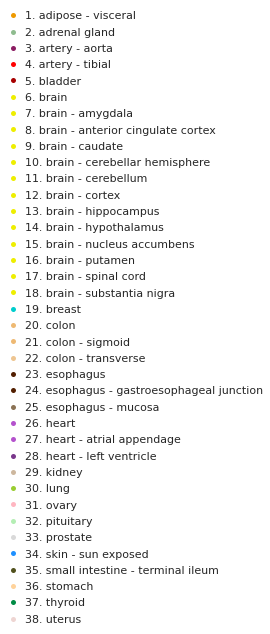

In [2898]:
sns.set(font_scale=1)
sns.set_style({'axes.facecolor':'white'})
fig, axes = plt.subplots(1,1,sharey=False,sharex=False,figsize=(0.2,0.3*len(tissue_df)))

ax = sns.swarmplot(data = tissue_df,x='x',y='tissue_label',
                 order=tissue_df['tissue_label'],palette=tissue_df['color_code']
                  )
ax.set(xticklabels = [],xlabel='',ylabel='')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(axis=u'both', which=u'both',length=0)
fig.savefig('./Figures/case_studies/GTEX_and_ProtDB_colors.png',bbox_inches='tight',dpi=300)
fig

In [2903]:
index_events

['DLG4_exon 17', 'GABBR1_exon 15', 'PTBP2_exon 10']

In [2926]:
# other validated USEs can be plotted with substitution of index_event and regulators list.

index_event = 'GABBR1_exon 15'
regulators = ['PTBP1']
gene_name = index_event.split('_')[0]
psi_data = nmd_sample_data.loc[nmd_sample_data['index_event']==index_event].reset_index(drop=True)
regulators_expr = aaf.get_gtex_expression_of_regulators(regulators)
psi_data = pd.merge(psi_data,regulators_expr[['sample_id']+regulators],how='left',on='sample_id')

directory = './Figures/case_studies/'+index_event.replace(' ','_').replace("'",'')
os.system('mkdir -p '+directory)

group_non_significant_tissues = True

if group_non_significant_tissues:
    tissues = list(ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
        ts_analysis_with_regulators['regulator'].isin(regulators))]['smtsd'].unique())
else:
    tissues = list(ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
        ts_analysis_with_regulators['regulator'].isin(regulators))&(ts_analysis_with_regulators['sign']==1)]['smtsd'].unique())
    
ts_analysis_res_cur = ts_analysis_res.loc[(ts_analysis_res['index_event']==index_event)&(ts_analysis_res['smtsd'].isin(tissues))]
ts_analysis_res_cur['tissue'] = ts_analysis_res_cur.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()
ts_analysis_res_cur = pd.merge(ts_analysis_res_cur,tissue_df[['tissue','tissue_number','color_code']],how='left',on='tissue')
ts_analysis_res_cur['tissue_number'] = ts_analysis_res_cur['tissue_number'].fillna(-1).astype('int')

if group_non_significant_tissues:
    ts_analysis_res_cur['tissue_cur'] = ts_analysis_res_cur.apply(lambda x:x['tissue'] if x['sign']==1 or x['smtsd'] in force_include_tissues else 'other tissues',1)
    ts_analysis_res_cur['color_code'] = ts_analysis_res_cur.apply(lambda x:x['color_code'] if x['sign']==1 or x['smtsd'] in force_include_tissues else 'white',1)
    ts_analysis_res_cur['tissue_number'] = ts_analysis_res_cur.apply(lambda x:str(x['tissue_number']) if x['sign']==1 or x['smtsd'] in force_include_tissues else 'other',1)
else:
    ts_analysis_res_cur['tissue_cur'] = ts_analysis_res_cur['tissue']
    
# Sort tissues in ascending order according to psi

if 'tissue_cur' in list(psi_data.columns):
    psi_data = psi_data.drop('tissue_cur',1)
psi_data = pd.merge(psi_data,ts_analysis_res_cur[['smtsd','tissue_cur']].drop_duplicates(),how='inner',on='smtsd')

psi_med = ts_analysis_res_cur['psi_med'].iloc[0]
global_expr_med = ts_analysis_res_cur['global_expr_med'].iloc[0]
local_expr_med = ts_analysis_res_cur['local_expr_med'].iloc[0]

ts_analysis_res_cur['psi_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['psi_fdr'],0.05),1)
ts_analysis_res_cur['psi_star'] = ts_analysis_res_cur.apply(lambda x:x['psi_star'] if (abs(x['delta_psi'])>0.05) and (x['tissue_cur']!='other tissues') else 'NS',1)

ts_analysis_res_cur['global_expr_fdr'] = ts_analysis_res_cur.apply(lambda x:x['global_expr_fdr'] if x['tissue_cur']!='other tissues' else 1,1)
ts_analysis_res_cur['local_expr_fdr'] = ts_analysis_res_cur.apply(lambda x:x['local_expr_fdr'] if x['tissue_cur']!='other tissues' else 1,1)
ts_analysis_res_cur['co_global'] = ts_analysis_res_cur.apply(lambda x:x['co_global'] if x['tissue_cur']!='other tissues' else 0,1)
ts_analysis_res_cur['co_local'] = ts_analysis_res_cur.apply(lambda x:x['co_local'] if x['tissue_cur']!='other tissues' else 0,1)

ts_analysis_res_cur['global_expr_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['global_expr_fdr'],0.05),1)
ts_analysis_res_cur['global_expr_color'] = ts_analysis_res_cur['co_global'].astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')
ts_analysis_res_cur['local_expr_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['local_expr_fdr'],0.05),1)
ts_analysis_res_cur['local_expr_color'] = ts_analysis_res_cur['co_local'].astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')

ts_analysis_res_cur = ts_analysis_res_cur.drop_duplicates('tissue_cur')
ts_analysis_res_cur['temp'] = (ts_analysis_res_cur['tissue_cur']=='other tissues').astype('int')
ts_analysis_res_cur = ts_analysis_res_cur.sort_values(['temp','psi'],ascending=[True,True]).reset_index(drop=True)

tissues = list(ts_analysis_res_cur['tissue_cur'])
palette = list(ts_analysis_res_cur['color_code'])
tissue_numbers = list(ts_analysis_res_cur['tissue_number'])

star_size=8

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1,2+len(regulators),sharey=False,sharex=False, 
                         figsize=(2*(3+len(regulators)),len(tissues)*0.22),
                        gridspec_kw={'width_ratios': [1,1]+[0.75]*len(regulators)})
ax = sns.boxplot(ax=axes[0],data=psi_data,y='tissue_cur',x='psi',order=tissues,palette=palette,showfliers=False,saturation=1)
ax.set(xlabel=r'$\psi$',ylabel='',yticklabels=tissue_numbers)
ax.axvline(psi_med,color='black',lw=1,ls='--')

ax2=ax.twinx()
ax2.set_yticks(ticks = list(ax.get_yticks())[::-1])
ax2.set_ybound(ax.get_ybound()[0],ax.get_ybound()[1])
stars = list(ts_analysis_res_cur['psi_star'])
ax2.set_yticklabels(stars,ha='center',size=star_size,color='black')

ax = sns.boxplot(ax=axes[1],data = psi_data,y='tissue_cur',x='global_expr',order=tissues,palette=palette,showfliers=False,saturation=1)
ax.set(xlabel='global expr.',ylabel='')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
stars = list(ts_analysis_res_cur['global_expr_star'])
ax.set_yticklabels(stars,ha='center',size=star_size)
colors = list(ts_analysis_res_cur['global_expr_color'])
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
ax.axvline(global_expr_med,color='black',lw=1,ls='--')

i=2
for regulator in regulators:
    ts_analysis_with_regulators_cur = ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
        ts_analysis_with_regulators['regulator']==regulator)]
    ts_analysis_with_regulators_cur['tissue_cur'] = ts_analysis_with_regulators_cur.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()
    ts_analysis_with_regulators_cur = pd.merge(pd.DataFrame(tissues,columns=['tissue_cur']),ts_analysis_with_regulators_cur,how='left',on='tissue_cur')
    ts_analysis_with_regulators_cur['fdr'] = ts_analysis_with_regulators_cur['fdr'].fillna(1)
    ts_analysis_with_regulators_cur['reg_co'] = ts_analysis_with_regulators_cur['reg_co'].fillna(0).astype('int')
    ts_analysis_with_regulators_cur['reg_TS'] = ts_analysis_with_regulators_cur['reg_TS'].fillna(0).astype('int')
    
    ts_analysis_with_regulators_cur['fdr'] = ts_analysis_with_regulators_cur.apply(lambda x:x['fdr'] if x['reg_TS']!=0 else 1,1)
    
    ts_analysis_with_regulators_cur['reg_expr_star'] = ts_analysis_with_regulators_cur.apply(lambda x:aaf.get_pvalue_star(x['fdr'],0.05),1)
    ts_analysis_with_regulators_cur['reg_expr_color'] = (ts_analysis_with_regulators_cur['reg_co']).astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')
    
    regulation_dir = str(int(ts_analysis_with_regulators_cur.loc[~ts_analysis_with_regulators_cur['regulation'].isna()]['regulation'].iloc[0])).replace('-1','NMD-inhib.').replace('1','NMD-prom.')
    med_reg_expr = ts_analysis_with_regulators_cur['reg_expr_med'].iloc[0]
    
    ax = sns.boxplot(ax=axes[i],data = psi_data,y='tissue_cur',x=regulator,order=tissues,palette=palette,showfliers=False,saturation=1)
    ax.set(xlabel=regulator+'\n'+regulation_dir,ylabel='')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    stars = list(ts_analysis_with_regulators_cur['reg_expr_star'])
    ax.set_yticklabels(stars,ha='center',size=star_size)
    colors = list(ts_analysis_with_regulators_cur['reg_expr_color'])
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.axvline(med_reg_expr,color='black',lw=1,ls='--')    
    i=i+1
fig.savefig(directory+'/TS_regulation.png',bbox_inches='tight',dpi=300)
# Fig F4, all sections except protein expression

ts_res_protDB_cur = ts_res_protDB.loc[(ts_res_protDB['index_event']==index_event)].sort_values('psi').reset_index(drop=True)
ts_res_protDB_cur['tissue'] = ts_res_protDB_cur.apply(lambda x:mofidy_protDB_tissues(x['TISSUE_NAME']),1).str.lower()
ts_res_protDB_cur = pd.merge(ts_res_protDB_cur,tissue_df[['tissue','color_code','tissue_number']],how='inner',on='tissue')

tissues_protDB = list(ts_res_protDB_cur['tissue'])
palette_protDB = list(ts_res_protDB_cur['color_code'])
tissue_numbers = list(ts_res_protDB_cur['tissue_number'])

protdf_protDB_cur = protdf_protDB.loc[protdf_protDB['gene_name']==gene_name]
protdf_protDB_cur['tissue'] = protdf_protDB_cur.apply(lambda x:mofidy_protDB_tissues(x['TISSUE_NAME']),1).str.lower()
jonckheere_pvals_cur = jonckheere_pvals.loc[jonckheere_pvals['index_event']==index_event]
jonckheere_star = aaf.get_pvalue_star(jonckheere_pvals_cur['fdr'].iloc[0],0.1)

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1,1,sharey=False,sharex=False, figsize=(1.5,len(tissues)*0.22))

ax = sns.swarmplot(data = protdf_protDB_cur,x='NORMALIZED_INTENSITY',y='tissue',order=tissues_protDB,palette=palette_protDB)
ax.set(xlabel='protein expr.',ylabel='',yticklabels=tissue_numbers)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(label='trend test: '+jonckheere_star,color='green' if jonckheere_star!='NS' else 'grey')

fig.savefig(directory+'/TS_regulation_ProtDB.png',bbox_inches='tight',dpi=300)
# Fig F4, protein expression

0

## regulatory network of unproductive splicing

In [2976]:
tmp1 = pd.merge(reg_expr_res.loc[(reg_expr_res['TS_with_regulator']==1)],binding[['index_event','regulator','binding_local','binding_gene']],
                how='left',on=['index_event','regulator'])[['index_event','as_class','stop_rel_position','regulator','regulation','# co','# anti','fdr_co','binding_local','binding_gene']].sort_values('fdr_co').reset_index(drop=True)
tmp1['Target'] = tmp1['index_event'].str.split('_',expand=True)[0]
tmp1['Target_gene_name'] = tmp1['index_event'].str.split('_',expand=True)[0]
tmp1['regulator_gene_name'] = tmp1['regulator']
tmp1['regulation'] = tmp1['regulation'].astype('str').str.replace('-1','NMD-inhibiting').replace('1','NMD-promoting')
tmp1['binding'] = tmp1['binding_local']+tmp1['binding_gene']

tmp1 = tmp1.loc[tmp1['binding']>0]

tmp1['t']=1
tmp2 = tmp1.groupby('regulator').agg({'t':sum}).reset_index().rename(columns={'t':'size'})
tmp2 = tmp2.sort_values('size',ascending=False).reset_index(drop=True)

In [2984]:
def get_size_cat(x):
    s = x['size']
    if s==1:
        cat = 1
    elif s<=3:
        cat = 2
    elif s<=10:
        cat = 3
    else:
        cat = 4
    return cat
tmp2['size_cat'] = tmp2.apply(lambda x:get_size_cat(x),1)

tmp1 = pd.merge(tmp1,tmp2[['regulator','size_cat']],how='left',on='regulator')
tmp1['size_cat'] = tmp1['size_cat'].fillna(0)
tmp1['minus_log_fdr_co'] = np.log10(tmp1['fdr_co'])*(-1)
tmp1['highly_TS'] = (tmp1['fdr_co']<0.001).astype('int')

In [3001]:
tmp1.loc[tmp1['highly_TS']==1]['fdr_co'].max(),tmp1.loc[tmp1['highly_TS']==0]['fdr_co'].max()

(0.0009602864583333, 0.0960077093553173)

In [2496]:
# clustering of regulated USEs with CLIP support in the gene

In [3004]:
# we reguire the expected change in splicing, gene expression and regulator's expression in considered tissues
ts_analysis_with_regulators['reg_DS'] = (ts_analysis_with_regulators['co_TS']==1).astype('int')*(ts_analysis_with_regulators['reg_co']==1).astype('int')*ts_analysis_with_regulators['DS']
ts_analysis_with_regulators['abs_reg_DS'] = abs(ts_analysis_with_regulators['reg_DS'])
data = ts_analysis_with_regulators.sort_values(['index_event','smtsd','abs_reg_DS'],ascending=[True,True,False]).reset_index(drop=True)[
    ['index_event','smtsd','reg_DS','abs_reg_DS']].drop_duplicates(keep='first').drop('abs_reg_DS',1)
data = data.loc[data['index_event'].isin(list(tmp1['index_event'].unique()))].reset_index(drop=True)
data['tissue'] = data.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()
data = data.loc[data['smtsd'].isin(list(data.loc[data['reg_DS']!=0]['smtsd'].unique()))]

In [3006]:
tissue_df = GTEX_color_codes.loc[GTEX_color_codes['smtsd'].isin(list(data['smtsd'].unique()))]
tissue_df = tissue_df.sort_values('tissue').reset_index(drop=True)
tissue_df['tissue_number'] = tissue_df.index+1
tissue_df['tissue_label'] = (tissue_df['tissue_number']).astype('str')+'. '+tissue_df['tissue']
tissue_df['x'] = 1

In [3008]:
data = pd.merge(data,tissue_df[['tissue','tissue_number']],how='left',on='tissue')

In [3009]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import fcluster

In [3010]:
pivot_matrix = pd.pivot_table(data=data,index='index_event',columns='tissue',values='reg_DS',fill_value=0).values
dist_matrix = squareform(pdist(pivot_matrix,metric='cosine'))
dist_matrix = pd.DataFrame(dist_matrix).fillna(1).values
linkage_events = hc.linkage(dist_matrix, method='median')

pivot_matrix = pd.pivot_table(data=data,index='tissue',columns='index_event',values='reg_DS',fill_value=0).values
dist_matrix = squareform(pdist(pivot_matrix,metric='cosine'))
dist_matrix = pd.DataFrame(dist_matrix).fillna(1).values
linkage_smtsd = hc.linkage(dist_matrix, method='median')

In [3011]:
pivot = pd.pivot_table(data=data,columns='index_event',index='tissue',values='reg_DS',fill_value=0)
tmp = tissue_df[['tissue','tissue_number','color_code']]
row_colors = list(pd.merge(pd.DataFrame(pivot.index),tmp,how='left',on='tissue')['color_code'])
yticklabels = list(pivot.index)

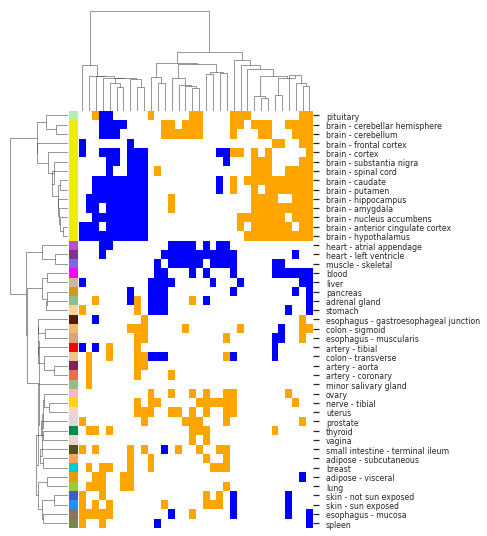

In [3012]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=True, figsize=(12,12))

sns.set(font_scale=0.7)

g = sns.clustermap(pivot,vmin=-1, vmax=1, center=0,cmap = ['blue','white','orange'],cbar_pos=None,
                    dendrogram_ratio=(0.2, 0.2),col_linkage=linkage_events,row_linkage=linkage_smtsd,
                    figsize=(7,12),row_colors = row_colors,yticklabels = yticklabels)

g.ax_heatmap.tick_params(right=True, bottom=False,labelbottom=False,rotation=0)
g.ax_heatmap.set(xlabel='',xticklabels=[],ylabel='')
fig = g.fig
fig.savefig('./Figures/regulated_clustermap.png',bbox_inches='tight',dpi=300)
fig
# Figure F5,A

In [3013]:
# distinguishing clusters
k=3
clusters = fcluster(linkage_events, k, criterion='maxclust')
tmp3 = pd.DataFrame(list(pivot.columns),columns=['index_event'])
tmp3['cluster'] = list(clusters)

def get_smtsd_short(x):
    if 'Brain' in x['smtsd']:
        return 'Brain'
    elif len([ele for ele in ['Muscle','Heart'] if(ele in x['smtsd'])])>0:
        return 'Muscle'
    elif len([ele for ele in ['Ovary','Uterus','Vagina'] if(ele in x['smtsd'])])>0:
        return 'Female reproductive system'
    elif 'Skin' in x['smtsd']:
        return 'Skin'
    else:
        return x['smtsd']
a = []
for cluster in list(tmp3['cluster'].unique()):
    l = list(tmp3.loc[tmp3['cluster']==cluster]['index_event'].unique())
    temp = data.loc[data['index_event'].isin(l)]
    temp['smtsd_short'] = temp.apply(lambda x:get_smtsd_short(x),1)
    temp = temp.groupby('smtsd_short').agg({'reg_DS':sum}).reset_index()
    temp['abs_reg_DS'] = abs(temp['reg_DS'])
    temp = temp.sort_values('abs_reg_DS',ascending=False).reset_index(drop=True)
    tissue = temp.iloc[0]['smtsd_short']
    direction = str(int(temp.iloc[0]['reg_DS']>0)*2-1)
    direction = direction.replace('-1','down').replace('1','up')
    a.append([cluster,tissue,direction])
temp = pd.DataFrame(a,columns=['cluster','tissue','direction'])
temp['cluster_name'] = temp['tissue']+'-'+temp['direction']

tmp3 = pd.merge(tmp3,temp[['cluster','cluster_name']],how='inner',on='cluster')
tmp1 = pd.merge(tmp1,tmp3[['index_event','cluster_name']],how='left',on='index_event')
tmp1 = tmp1[['Target','Target_gene_name','cluster_name','regulator','regulator_gene_name','size_cat','regulation','binding','highly_TS']]

In [3018]:
Counter(tmp1['cluster_name'])

Counter({'Brain-up': 38, 'Brain-down': 19, 'Muscle-down': 18})

In [ ]:
os.system('mkdir -p ./novel_events_catalog/network/')

In [3019]:
tmp1.to_csv('./novel_events_catalog/network/ts_pairs.tsv', sep=str('\t'),header=True,index=None)
# these data is further used in cytoscape to plot the network

## Annotated USEs

In [3042]:
tmp1 = pd.merge(reg_expr_res.loc[(reg_expr_res['TS_with_regulator']==1)],binding[['index_event','regulator','binding_local','binding_gene']],
                how='left',on=['index_event','regulator'])[['index_event','as_class','stop_rel_position','regulator','regulation','# co','# anti','fdr_co','binding_local','binding_gene']].sort_values('fdr_co').reset_index(drop=True)
tmp1['Target'] = tmp1['index_event'].str.split('_',expand=True)[0]
tmp1['Target_gene_name'] = tmp1['index_event'].str.split('_',expand=True)[0]
tmp1['regulator_gene_name'] = tmp1['regulator']
tmp1['regulation'] = tmp1['regulation'].astype('str').str.replace('-1','NMD-inhibiting').replace('1','NMD-promoting')
tmp1['binding'] = tmp1['binding_local']+tmp1['binding_gene']
tmp1 = tmp1.loc[tmp1['binding']>0]

In [3047]:
targets = tmp1[['index_event','as_class','stop_rel_position']]
targets['lit'] = (~targets['index_event'].str.contains('chr')).astype('int')
targets = targets.loc[(targets['lit']==0)]
targets = targets.drop_duplicates().reset_index(drop=True)

In [3053]:
nmd_sample_data_list = []

In [3054]:
# poison exons
as_classes = ['poison exon']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_poison_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['coding_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['NMD_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

NMD_cols = ['NMD_upst_junction','NMD_downst_junction']
can_cols = ['coding_skip_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

done: 0 out of 9


In [3055]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3056]:
# essential exons
as_classes = ['essential exon']
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_essential_exons.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']
nmd_sample['NMD_skip_junction'] = nmd_sample['chr']+'_'+nmd_sample['skip_junction']+'_'+nmd_sample['str']
nmd_sample['coding_upst_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_junction']+'_'+nmd_sample['str']
nmd_sample['coding_downst_junction'] = nmd_sample['chr']+'_'+nmd_sample['downst_junction']+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_skip_junction']
can_cols = ['coding_upst_junction','coding_downst_junction']

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

done: 0 out of 14


In [3057]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3058]:
# alt starts
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_starts.tsv',delimiter="\t",
                                   index_col=None,header=0)

nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+\
nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

done: 0 out of 4


In [3059]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3060]:
# alt ends
as_classes = ["poison 5' splice site","essential 5' splice site","poison 3' splice site","essential 3' splice site"]
nmd_sample = pd.read_csv('./novel_events_catalog/hg19_alt_ends.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+\
nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['flank_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['flank_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_junction']

if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

done: 0 out of 3


In [3061]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3062]:
# intron retention
as_classes = ['intron retention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_retention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['exon_start'].astype('str')+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+\
nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['coding_junction'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['exon_end_coding'].astype('str')+'_'+nmd_sample['str']
nmd_sample['NMD_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start_coding'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_site_upst','NMD_site_downst']
can_cols = ['coding_junction']

if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

done: 0 out of 1


In [3063]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3064]:
# intron detention
as_classes = ['intron detention']

nmd_sample = pd.read_csv('./novel_events_catalog/hg19_intron_detention.tsv',delimiter="\t",
                                   index_col=None,header=0)
nmd_sample['AS event position'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_start'].astype('str')+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+\
nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['downst_exon_end'].astype('str')+'_'+nmd_sample['str']

nmd_sample['index_event'] = nmd_sample['gene_name']+'_'+nmd_sample['AS event position']

nmd_sample['NMD_junction'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_upst'] = nmd_sample['chr']+'_'+nmd_sample['upst_exon_end'].astype('str')+'_'+nmd_sample['str']
nmd_sample['coding_site_downst'] = nmd_sample['chr']+'_'+nmd_sample['downst_exon_start'].astype('str')+'_'+nmd_sample['str']

nmd_sample.rename(columns={'gene_name':'Target'},inplace=True)
nmd_sample = nmd_sample.drop_duplicates(['Target','AS event position'])

nmd_sample = pd.merge(nmd_sample,targets.loc[targets['as_class'].isin(as_classes)][['index_event']].drop_duplicates(),how='inner',on=['index_event'])

NMD_cols = ['NMD_junction']
can_cols = ['coding_site_upst','coding_site_downst']
if len(nmd_sample)>0:
    summary,nmd_sample_data = aaf.get_GTEX_summary_pooled(nmd_sample,NMD_cols,can_cols,True)
else:
    nmd_sample_data = []

In [3065]:
nmd_sample_data_list = nmd_sample_data_list+nmd_sample_data

In [3066]:
len(nmd_sample_data_list)

31

In [3067]:
nmd_sample_data = pd.concat(nmd_sample_data_list).reset_index(drop=True)
nmd_sample_data['index_event'] = nmd_sample_data['gene_name']+'_'+nmd_sample_data['AS_event_position']

In [3159]:
genes_of_interest = ['DCLK2', 'IQGAP1', 'ACSF3']
index_events = list(targets.loc[targets['index_event'].str.contains('|'.join(genes_of_interest))]['index_event'])

In [3161]:
force_include_tissues = ['Adrenal Gland','Bladder','Colon - Sigmoid','Colon - Transverse',
                         'Lung','Prostate','Ovary','Uterus','Stomach','Heart - Atrial Appendage',
                         'Heart - Left Ventricle','Brain - Cortex','Thyroid','Brain - Spinal cord (cervical c-1)',
                        'Breast - Mammary Tissue','Kidney - Cortex','Adipose - Subcutaneous','Adipose - Visceral (Omentum)']

In [3162]:
smtsd_to_show = list(ts_analysis_res.loc[((ts_analysis_res['index_event'].isin(index_events))&(ts_analysis_res['sign']==1))|(
ts_analysis_res['smtsd'].isin(force_include_tissues))][['smtsd']].drop_duplicates().sort_values('smtsd')['smtsd'])
ProtDB_tissues_to_show = list(ts_res_protDB.loc[(ts_res_protDB['index_event'].isin(index_events))][['TISSUE_NAME']].drop_duplicates().sort_values('TISSUE_NAME')['TISSUE_NAME'])

smtsd_to_show = list(pd.Series(smtsd_to_show).apply(mofidy_GTEx_tissues).str.lower())
ProtDB_tissues_to_show = list(pd.Series(ProtDB_tissues_to_show).apply(mofidy_protDB_tissues).str.lower())

tissue_df = pd.DataFrame(pd.Series(unique(ProtDB_tissues_to_show+smtsd_to_show)).sort_values(),columns=['tissue'])
tissue_df['tissue_number'] = tissue_df.index+1
tissue_df['tissue_label'] = (tissue_df['tissue_number']).astype('str')+'. '+tissue_df['tissue']

tissue_df = pd.merge(tissue_df,GTEX_color_codes[['tissue','color_code']],how='left',on='tissue')
tissue_df = pd.merge(tissue_df,
         all_ProtDB_tissues_x_smtsd[['tissue','color_code']].drop_duplicates().rename(columns={'color_code':'color_code_2'}),
         how='left', 
         on = 'tissue')
tissue_df['color_code'] = tissue_df.apply(lambda x:x['color_code_2'] if x['color_code'] is NaN else x['color_code'],1)
tissue_df = tissue_df.drop('color_code_2',1)

tissue_df['y'] = tissue_df.index
tissue_df['x'] = 1

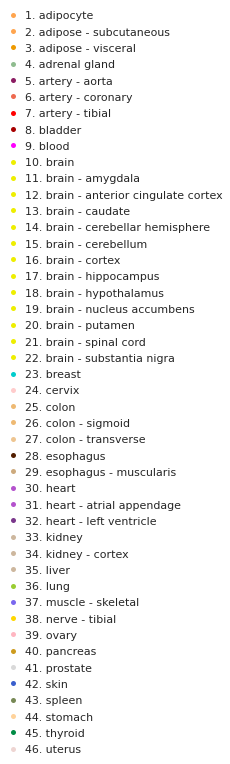

In [3165]:
sns.set(font_scale=1)
sns.set_style({'axes.facecolor':'white'})
fig, axes = plt.subplots(1,1,sharey=False,sharex=False,figsize=(0.2,0.3*len(tissue_df)))

ax = sns.swarmplot(data = tissue_df,x='x',y='tissue_label',
#                    hue='tissue_label',
                 order=tissue_df['tissue_label'],palette=tissue_df['color_code']
                  )
ax.set(xticklabels = [],xlabel='',ylabel='')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(axis=u'both', which=u'both',length=0)
fig.savefig('./Figures/case_studies/GTEX_and_ProtDB_colors.png',bbox_inches='tight',dpi=300)
fig

In [3166]:
index_events

['DCLK2_chr4_151170836_151174626_151174708_151177172_+',
 'ACSF3_chr16_89178654_89180747_89180895_89187209_+',
 'IQGAP1_chr15_91025513_91025934_91025981_91026593_+']

In [3167]:
for index_event in index_events:
    regulators = list(tmp1.loc[(tmp1['index_event']==index_event)&(tmp1['binding']>0)]['regulator'])
    gene_name = index_event.split('_')[0]
    psi_data = nmd_sample_data.loc[nmd_sample_data['index_event']==index_event].reset_index(drop=True)
    regulators_expr = aaf.get_gtex_expression_of_regulators(regulators)
    psi_data = pd.merge(psi_data,regulators_expr[['sample_id']+regulators],how='left',on='sample_id')
    directory = './Figures/case_studies/'+index_event.replace(' ','_').replace("'",'')
    os.system('mkdir -p '+directory)
    
    group_non_significant_tissues = True

    if group_non_significant_tissues:
        tissues = list(ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
            ts_analysis_with_regulators['regulator'].isin(regulators))]['smtsd'].unique())
    else:
        tissues = list(ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
            ts_analysis_with_regulators['regulator'].isin(regulators))&(ts_analysis_with_regulators['sign']==1)]['smtsd'].unique())
    
    ts_analysis_res_cur = ts_analysis_res.loc[(ts_analysis_res['index_event']==index_event)&(ts_analysis_res['smtsd'].isin(tissues))]
    ts_analysis_res_cur['tissue'] = ts_analysis_res_cur.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()
    ts_analysis_res_cur = pd.merge(ts_analysis_res_cur,tissue_df[['tissue','tissue_number','color_code']],how='left',on='tissue')
    ts_analysis_res_cur['tissue_number'] = ts_analysis_res_cur['tissue_number'].fillna(-1).astype('int')

    if group_non_significant_tissues:
        ts_analysis_res_cur['tissue_cur'] = ts_analysis_res_cur.apply(lambda x:x['tissue'] if x['sign']==1 or x['smtsd'] in force_include_tissues else 'other tissues',1)
        ts_analysis_res_cur['color_code'] = ts_analysis_res_cur.apply(lambda x:x['color_code'] if x['sign']==1 or x['smtsd'] in force_include_tissues else 'white',1)
        ts_analysis_res_cur['tissue_number'] = ts_analysis_res_cur.apply(lambda x:str(x['tissue_number']) if x['sign']==1 or x['smtsd'] in force_include_tissues else 'other',1)
    else:
        ts_analysis_res_cur['tissue_cur'] = ts_analysis_res_cur['tissue']
        
    # расположим в правильном порядке
    if 'tissue_cur' in list(psi_data.columns):
        psi_data = psi_data.drop('tissue_cur',1)
    psi_data = pd.merge(psi_data,ts_analysis_res_cur[['smtsd','tissue_cur']].drop_duplicates(),how='inner',on='smtsd')

    psi_med = ts_analysis_res_cur['psi_med'].iloc[0]
    global_expr_med = ts_analysis_res_cur['global_expr_med'].iloc[0]
    local_expr_med = ts_analysis_res_cur['local_expr_med'].iloc[0]

    ts_analysis_res_cur['psi_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['psi_fdr'],0.05),1)
    ts_analysis_res_cur['psi_star'] = ts_analysis_res_cur.apply(lambda x:x['psi_star'] if (abs(x['delta_psi'])>0.05) and (x['tissue_cur']!='other tissues') else 'NS',1)

    ts_analysis_res_cur['global_expr_fdr'] = ts_analysis_res_cur.apply(lambda x:x['global_expr_fdr'] if x['tissue_cur']!='other tissues' else 1,1)
    ts_analysis_res_cur['local_expr_fdr'] = ts_analysis_res_cur.apply(lambda x:x['local_expr_fdr'] if x['tissue_cur']!='other tissues' else 1,1)
    ts_analysis_res_cur['co_global'] = ts_analysis_res_cur.apply(lambda x:x['co_global'] if x['tissue_cur']!='other tissues' else 0,1)
    ts_analysis_res_cur['co_local'] = ts_analysis_res_cur.apply(lambda x:x['co_local'] if x['tissue_cur']!='other tissues' else 0,1)

    ts_analysis_res_cur['global_expr_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['global_expr_fdr'],0.05),1)
    ts_analysis_res_cur['global_expr_color'] = ts_analysis_res_cur['co_global'].astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')
    ts_analysis_res_cur['local_expr_star'] = ts_analysis_res_cur.apply(lambda x:aaf.get_pvalue_star(x['local_expr_fdr'],0.05),1)
    ts_analysis_res_cur['local_expr_color'] = ts_analysis_res_cur['co_local'].astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')

    ts_analysis_res_cur = ts_analysis_res_cur.drop_duplicates('tissue_cur')
    ts_analysis_res_cur['temp'] = (ts_analysis_res_cur['tissue_cur']=='other tissues').astype('int')
    ts_analysis_res_cur = ts_analysis_res_cur.sort_values(['temp','psi'],ascending=[True,True]).reset_index(drop=True)

    tissues = list(ts_analysis_res_cur['tissue_cur'])
    palette = list(ts_analysis_res_cur['color_code'])
    tissue_numbers = list(ts_analysis_res_cur['tissue_number'])
    
    star_size=8

    sns.set(font_scale=1)
    sns.set_style("white")
    fig, axes = plt.subplots(1,2+len(regulators),sharey=False,sharex=False, 
                             figsize=(2*(3+len(regulators)),len(tissues)*0.22),
                            gridspec_kw={'width_ratios': [1,1]+[0.75]*len(regulators)})
    ax = sns.boxplot(ax=axes[0],data=psi_data,y='tissue_cur',x='psi',order=tissues,palette=palette,showfliers=False,saturation=1)
    ax.set(xlabel=r'$\psi$',ylabel='',yticklabels=tissue_numbers)
    ax.axvline(psi_med,color='black',lw=1,ls='--')

    ax2=ax.twinx()
    ax2.set_yticks(ticks = list(ax.get_yticks())[::-1])
    ax2.set_ybound(ax.get_ybound()[0],ax.get_ybound()[1])
    stars = list(ts_analysis_res_cur['psi_star'])
    ax2.set_yticklabels(stars,ha='center',size=star_size,color='black')

    ax = sns.boxplot(ax=axes[1],data = psi_data,y='tissue_cur',x='global_expr',order=tissues,palette=palette,showfliers=False,saturation=1)
    ax.set(xlabel='global expr.',ylabel='')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    stars = list(ts_analysis_res_cur['global_expr_star'])
    ax.set_yticklabels(stars,ha='center',size=star_size)
    colors = list(ts_analysis_res_cur['global_expr_color'])
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.axvline(global_expr_med,color='black',lw=1,ls='--')

    i=2
    for regulator in regulators:
        ts_analysis_with_regulators_cur = ts_analysis_with_regulators.loc[(ts_analysis_with_regulators['index_event']==index_event)&(
            ts_analysis_with_regulators['regulator']==regulator)]
        ts_analysis_with_regulators_cur['tissue_cur'] = ts_analysis_with_regulators_cur.apply(lambda x:mofidy_GTEx_tissues(x['smtsd']),1).str.lower()
        ts_analysis_with_regulators_cur = pd.merge(pd.DataFrame(tissues,columns=['tissue_cur']),ts_analysis_with_regulators_cur,how='left',on='tissue_cur')
        ts_analysis_with_regulators_cur['fdr'] = ts_analysis_with_regulators_cur['fdr'].fillna(1)
        ts_analysis_with_regulators_cur['reg_co'] = ts_analysis_with_regulators_cur['reg_co'].fillna(0).astype('int')
        ts_analysis_with_regulators_cur['reg_TS'] = ts_analysis_with_regulators_cur['reg_TS'].fillna(0).astype('int')

        ts_analysis_with_regulators_cur['fdr'] = ts_analysis_with_regulators_cur.apply(lambda x:x['fdr'] if x['reg_TS']!=0 else 1,1)

        ts_analysis_with_regulators_cur['reg_expr_star'] = ts_analysis_with_regulators_cur.apply(lambda x:aaf.get_pvalue_star(x['fdr'],0.05),1)
        ts_analysis_with_regulators_cur['reg_expr_color'] = (ts_analysis_with_regulators_cur['reg_co']).astype('str').str.replace('-1','red').replace('1','green').replace('0','grey')

        regulation_dir = str(int(ts_analysis_with_regulators_cur.loc[~ts_analysis_with_regulators_cur['regulation'].isna()]['regulation'].iloc[0])).replace('-1','NMD-inhib.').replace('1','NMD-prom.')
        med_reg_expr = ts_analysis_with_regulators_cur['reg_expr_med'].iloc[0]

        ax = sns.boxplot(ax=axes[i],data = psi_data,y='tissue_cur',x=regulator,order=tissues,palette=palette,showfliers=False,saturation=1)
        ax.set(xlabel=regulator+'\n'+regulation_dir,ylabel='')
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        stars = list(ts_analysis_with_regulators_cur['reg_expr_star'])
        ax.set_yticklabels(stars,ha='center',size=star_size)
        colors = list(ts_analysis_with_regulators_cur['reg_expr_color'])
        for ytick, color in zip(ax.get_yticklabels(), colors):
            ytick.set_color(color)
        ax.axvline(med_reg_expr,color='black',lw=1,ls='--')    
        i=i+1
    fig.savefig(directory+'/TS_regulation.png',bbox_inches='tight',dpi=300)
    
    ts_res_protDB_cur = ts_res_protDB.loc[(ts_res_protDB['index_event']==index_event)].sort_values('psi').reset_index(drop=True)
    ts_res_protDB_cur['tissue'] = ts_res_protDB_cur.apply(lambda x:mofidy_protDB_tissues(x['TISSUE_NAME']),1).str.lower()
    ts_res_protDB_cur = pd.merge(ts_res_protDB_cur,tissue_df[['tissue','color_code','tissue_number']],how='inner',on='tissue')

    tissues_protDB = list(ts_res_protDB_cur['tissue'])
    palette_protDB = list(ts_res_protDB_cur['color_code'])
    tissue_numbers = list(ts_res_protDB_cur['tissue_number'])

    protdf_protDB_cur = protdf_protDB.loc[protdf_protDB['gene_name']==gene_name]
    protdf_protDB_cur['tissue'] = protdf_protDB_cur.apply(lambda x:mofidy_protDB_tissues(x['TISSUE_NAME']),1).str.lower()
    jonckheere_pvals_cur = jonckheere_pvals.loc[jonckheere_pvals['index_event']==index_event]
    jonckheere_star = aaf.get_pvalue_star(jonckheere_pvals_cur['fdr'].iloc[0],0.1)
    
    sns.set(font_scale=1)
    sns.set_style("white")
    fig, axes = plt.subplots(1,1,sharey=False,sharex=False, figsize=(1.5,len(tissues)*0.22))

    ax = sns.swarmplot(data = protdf_protDB_cur,x='NORMALIZED_INTENSITY',y='tissue',order=tissues_protDB,palette=palette_protDB)
    ax.set(xlabel='protein expr.',ylabel='',yticklabels=tissue_numbers)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_title(label='trend test: '+jonckheere_star,color='green' if jonckheere_star!='NS' else 'grey')

    fig.savefig(directory+'/TS_regulation_ProtDB.png',bbox_inches='tight',dpi=300)
    
    print('done '+index_event)
    # Fig F6

done DCLK2_chr4_151170836_151174626_151174708_151177172_+
done ACSF3_chr16_89178654_89180747_89180895_89187209_+
done IQGAP1_chr15_91025513_91025934_91025981_91026593_+
